This notebook demonstrates performance of RNN model. It also saves/loads some data and figures. Model's parameters can be changed in the corresponding sections here.

In [1]:
# add path to ssa package
import sys
sys.path.append('../../..')

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter 

import pathlib
import pickle
import IPython.display as display

%matplotlib inline 

In [3]:
# rnn model
from src.rnn import data, model, train

# plot with large fonts and other stuff
from src.plot.journal_style import EnableJournalStylePlotting

# data extraction methods
from src.data.accelerometer_1 import GetWalkData

## Data preprocessing

In [4]:
# names of observed signals
sig_names = ['$a_x$', '$a_y$', '$a_z$', '$w_x$', '$w_y$', '$w_z$']
# measure units
# acceleration is in g-units (g=9.8)
sig_units = ["m/$s^2$", "m/$s^2$", "m/$s^2$", "rad/s", "rad/s", "rad/s"]

num_signals = 6

In [5]:
# retrive signals and corresponding time grids
# this is walking motion
# first 3 components = accelerometer, last 3 - gyroscope
(train_data, time_grid_train), (test_data, time_grid_test) = GetWalkData()

print("Train len = ", train_data.shape[0])
print("Test len = ", test_data.shape[0])

Train len =  1375
Test len =  302


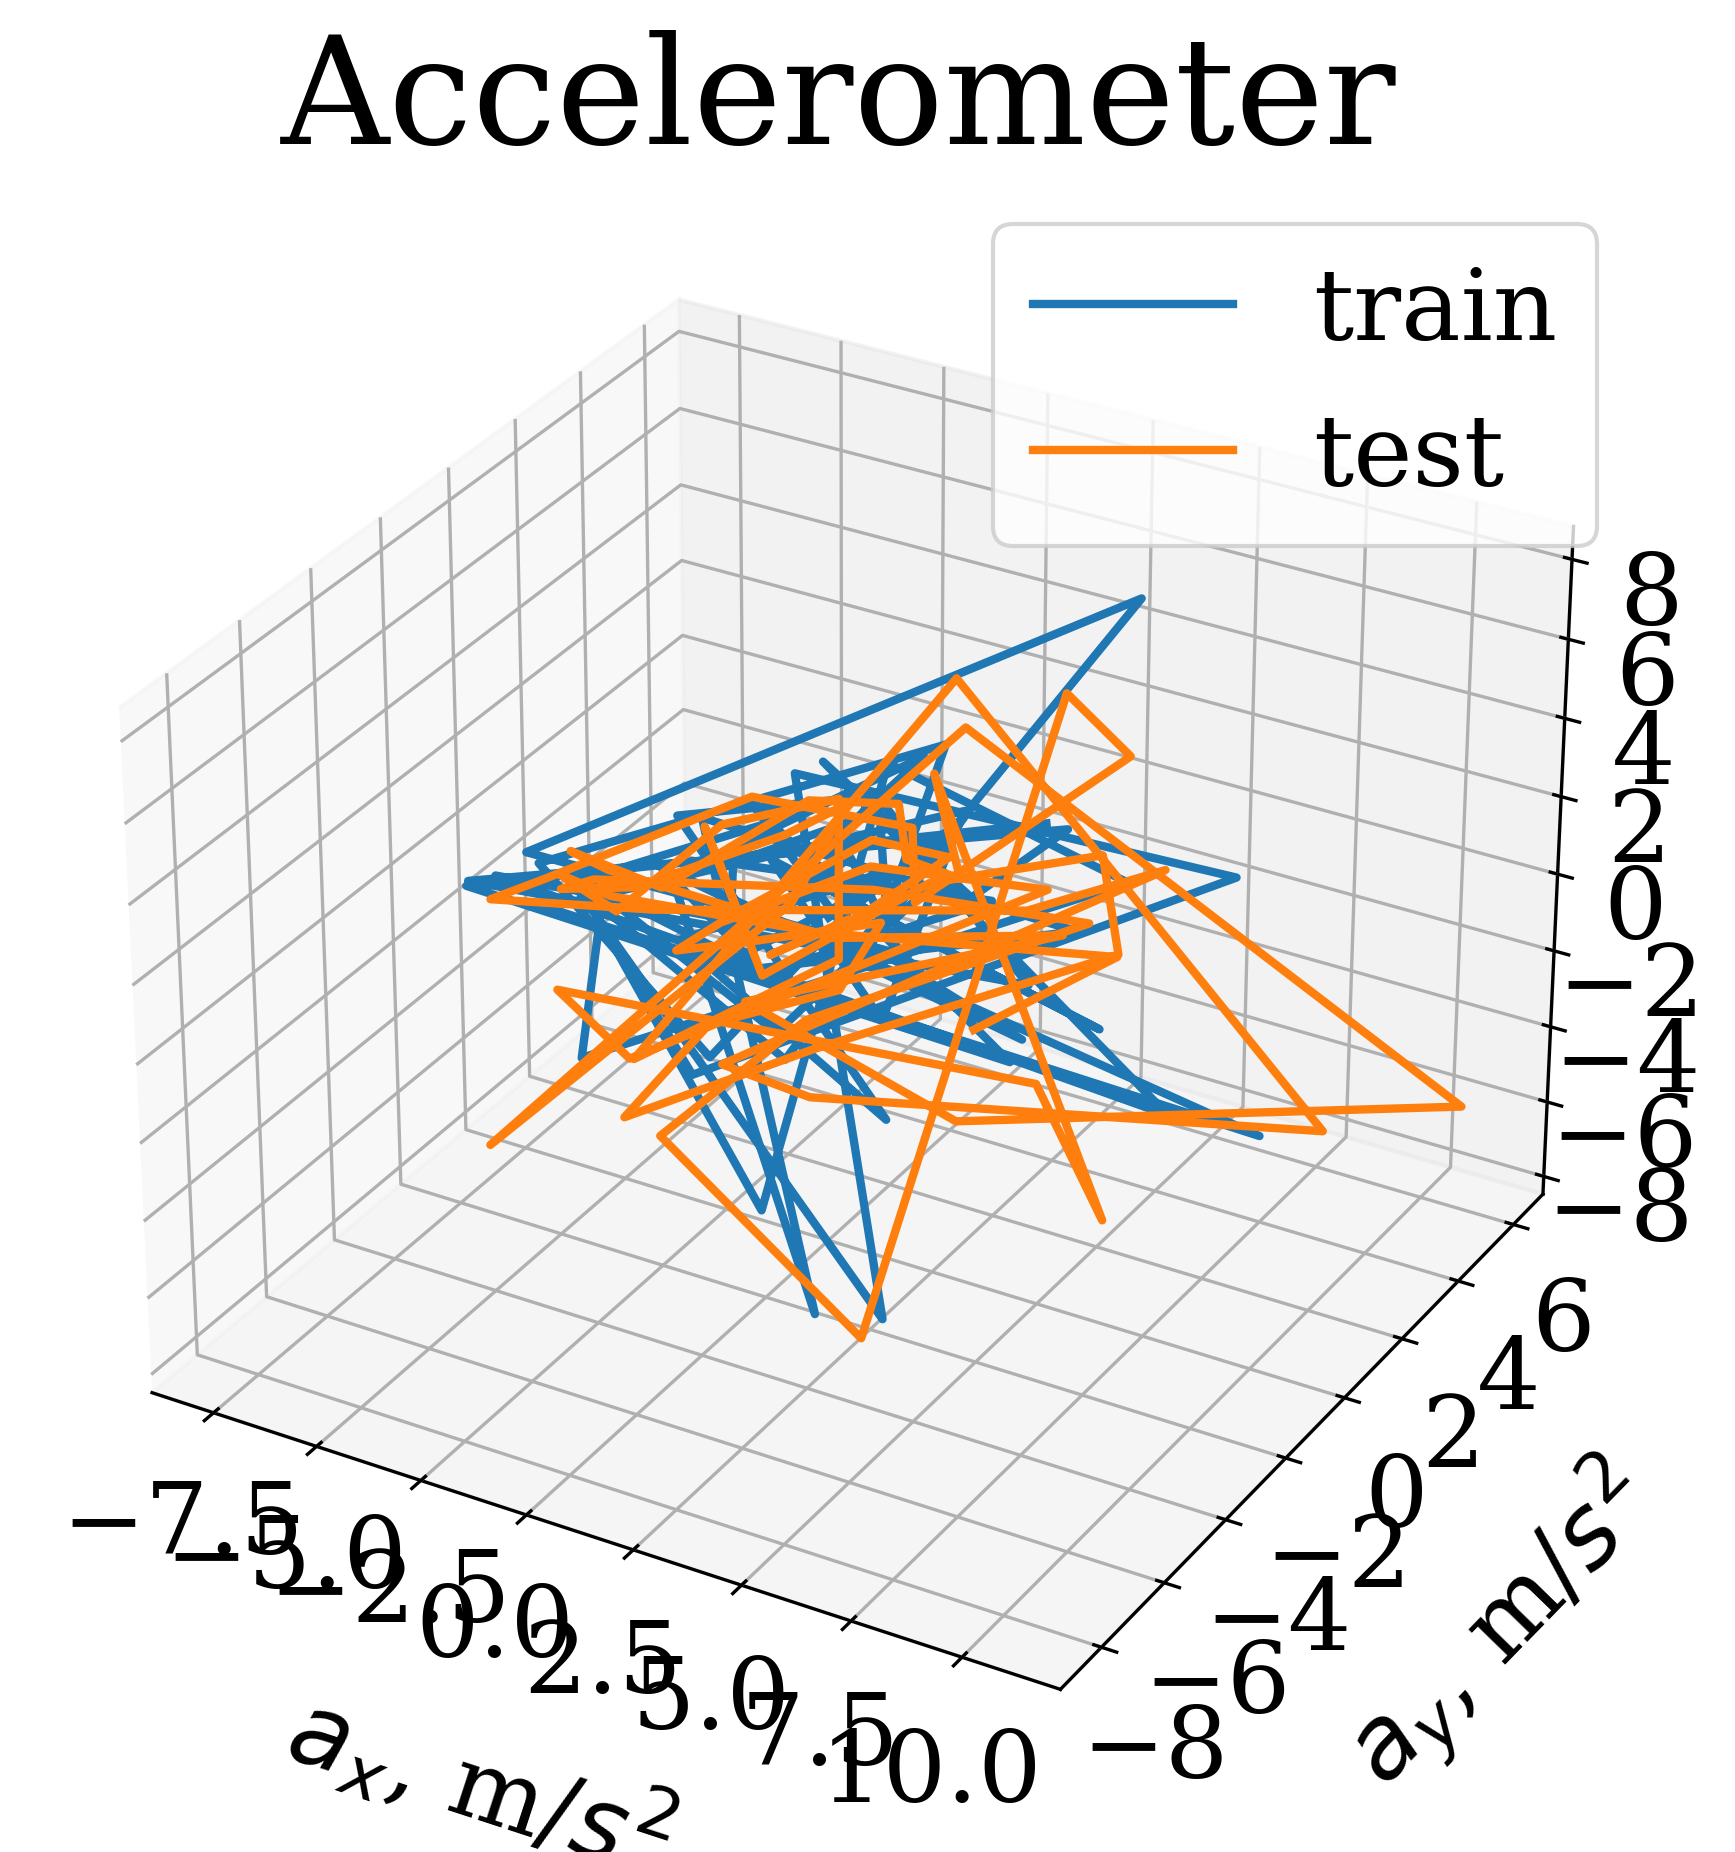

In [6]:
# draw accelerometer signals
with EnableJournalStylePlotting():
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(projection='3d')
    
    train_points = train_data.T[:3, ::20]
    test_points = test_data.T[:3, ::4]
    
    ax.plot(*train_points, label="train")
    ax.plot(*test_points, label="test")
    
    ax.set_xlabel(f"{sig_names[0]}, {sig_units[0]}", labelpad=21)
    ax.set_ylabel(f"{sig_names[1]}, {sig_units[1]}", labelpad=21)
    ax.set_zlabel(f"{sig_names[2]}, {sig_units[2]}", labelpad=21)
    ax.set_title("Accelerometer")
    ax.legend()

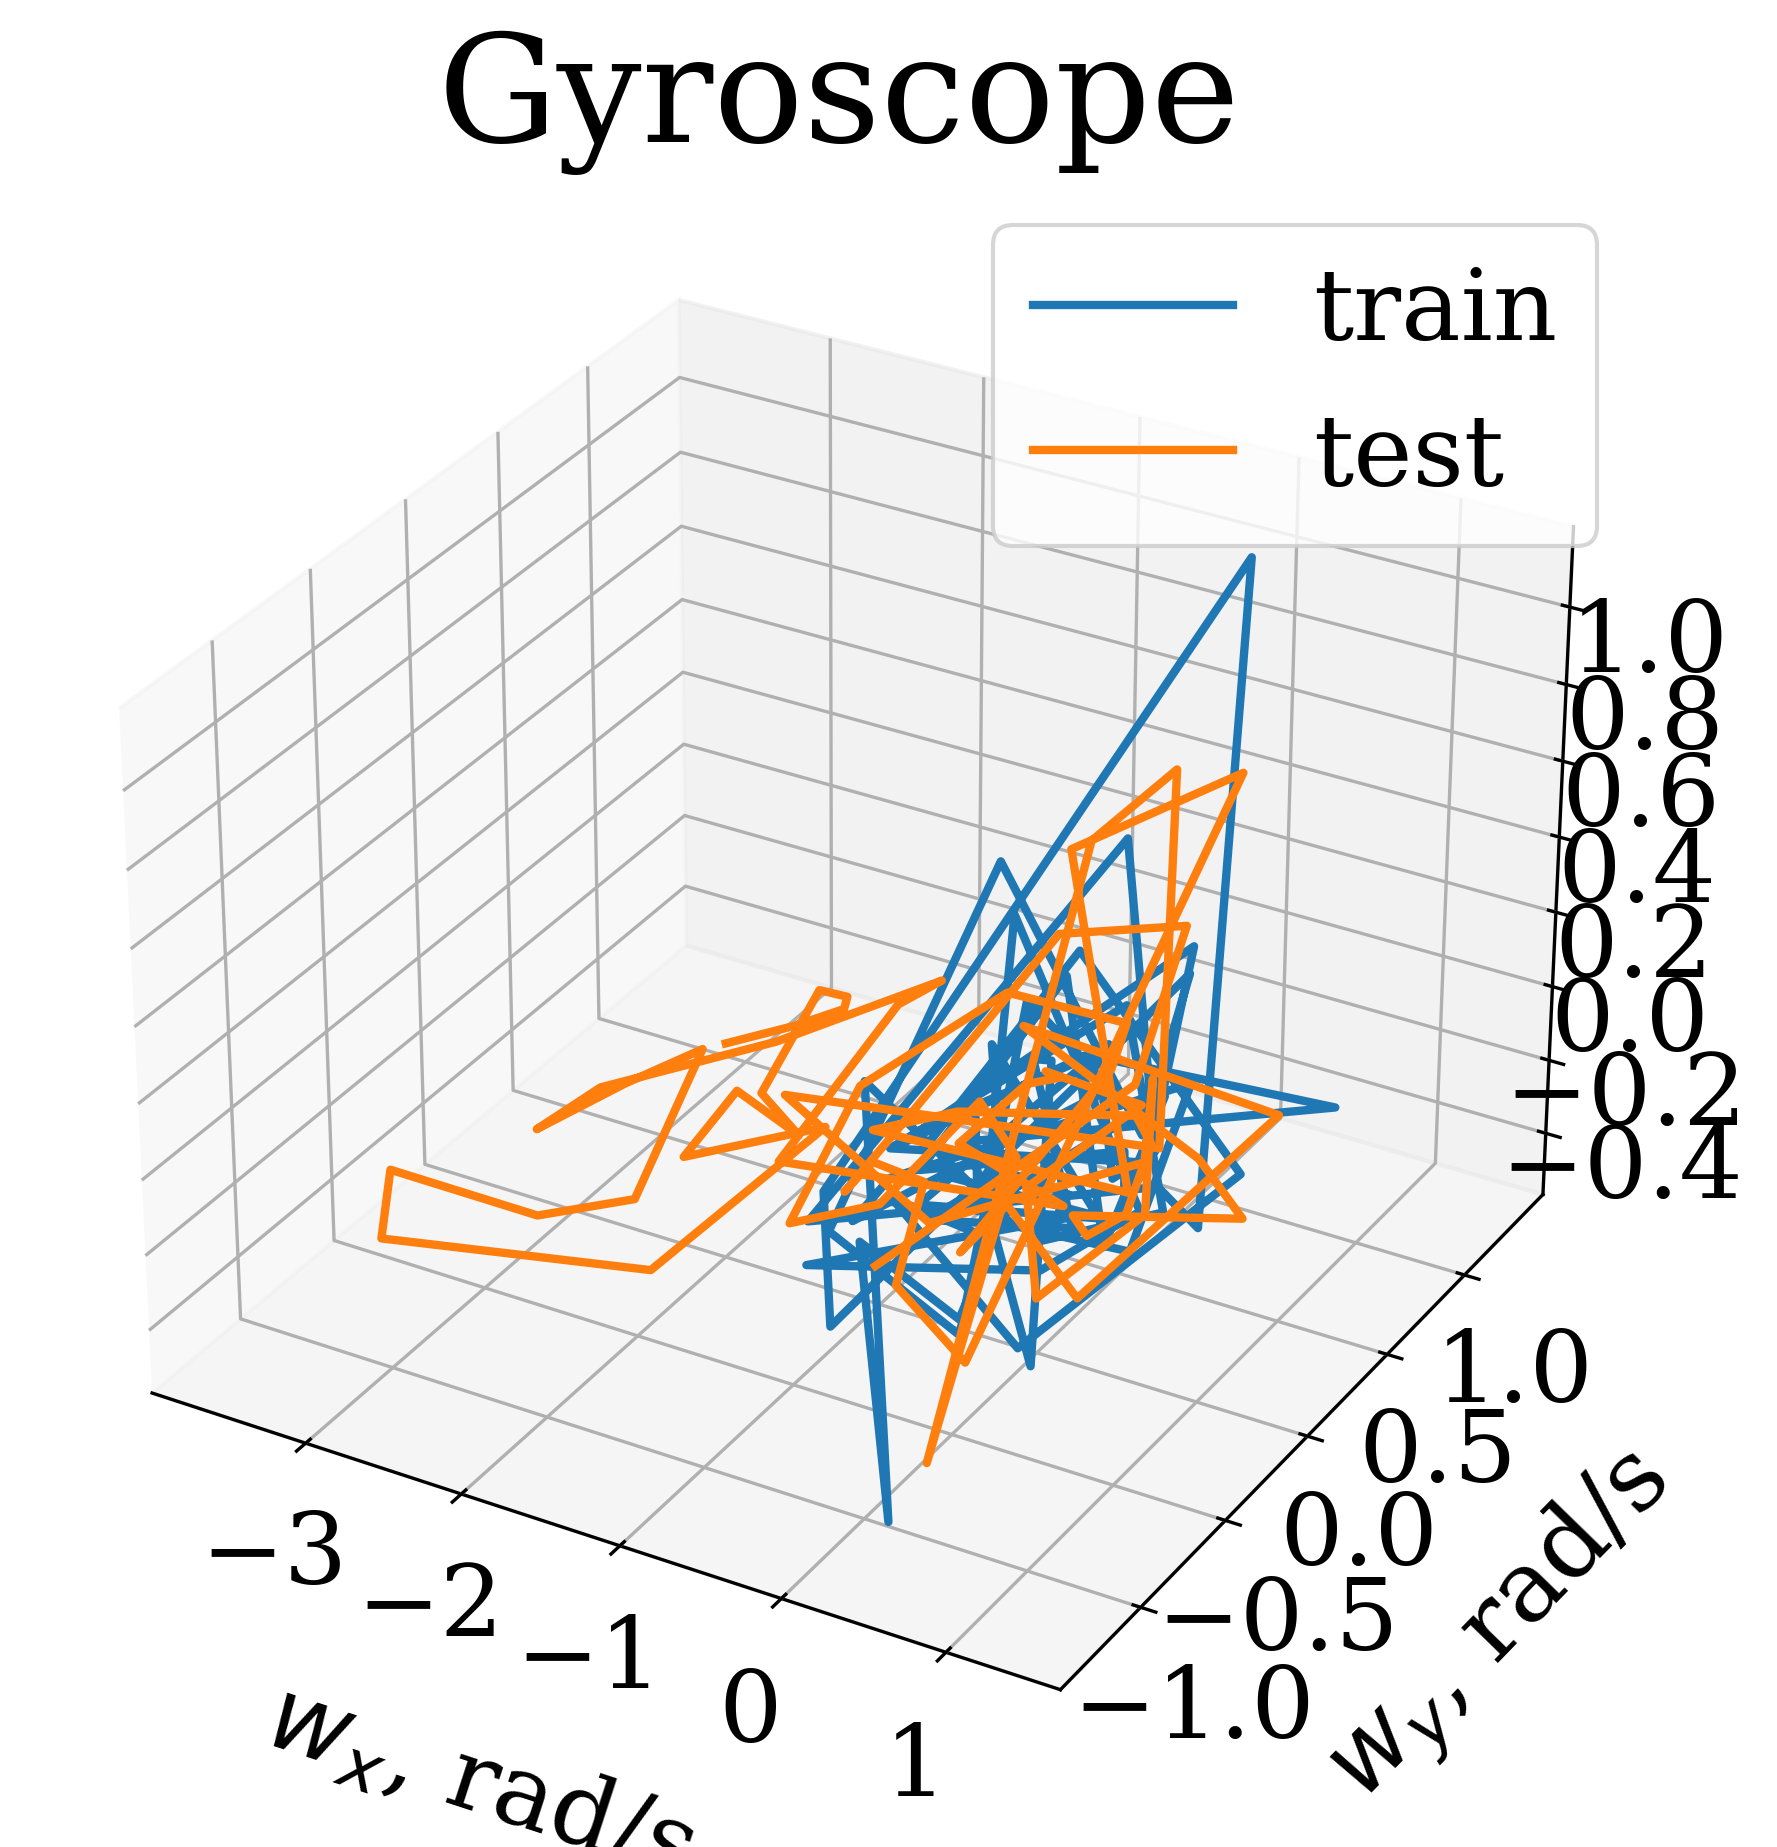

In [7]:
# draw gyro signals
with EnableJournalStylePlotting():
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(projection='3d')

    train_points = train_data.T[3:, ::20]
    test_points = test_data.T[3:, ::4]

    ax.plot(*train_points, label="train")
    ax.plot(*test_points, label="test")

    ax.set_xlabel(f"{sig_names[3]}, {sig_units[3]}", labelpad=21)
    ax.set_ylabel(f"{sig_names[4]}, {sig_units[4]}", labelpad=21)
    ax.set_zlabel(f"{sig_names[5]}, {sig_units[5]}", labelpad=21)
    ax.set_title("Gyroscope")
    ax.legend()

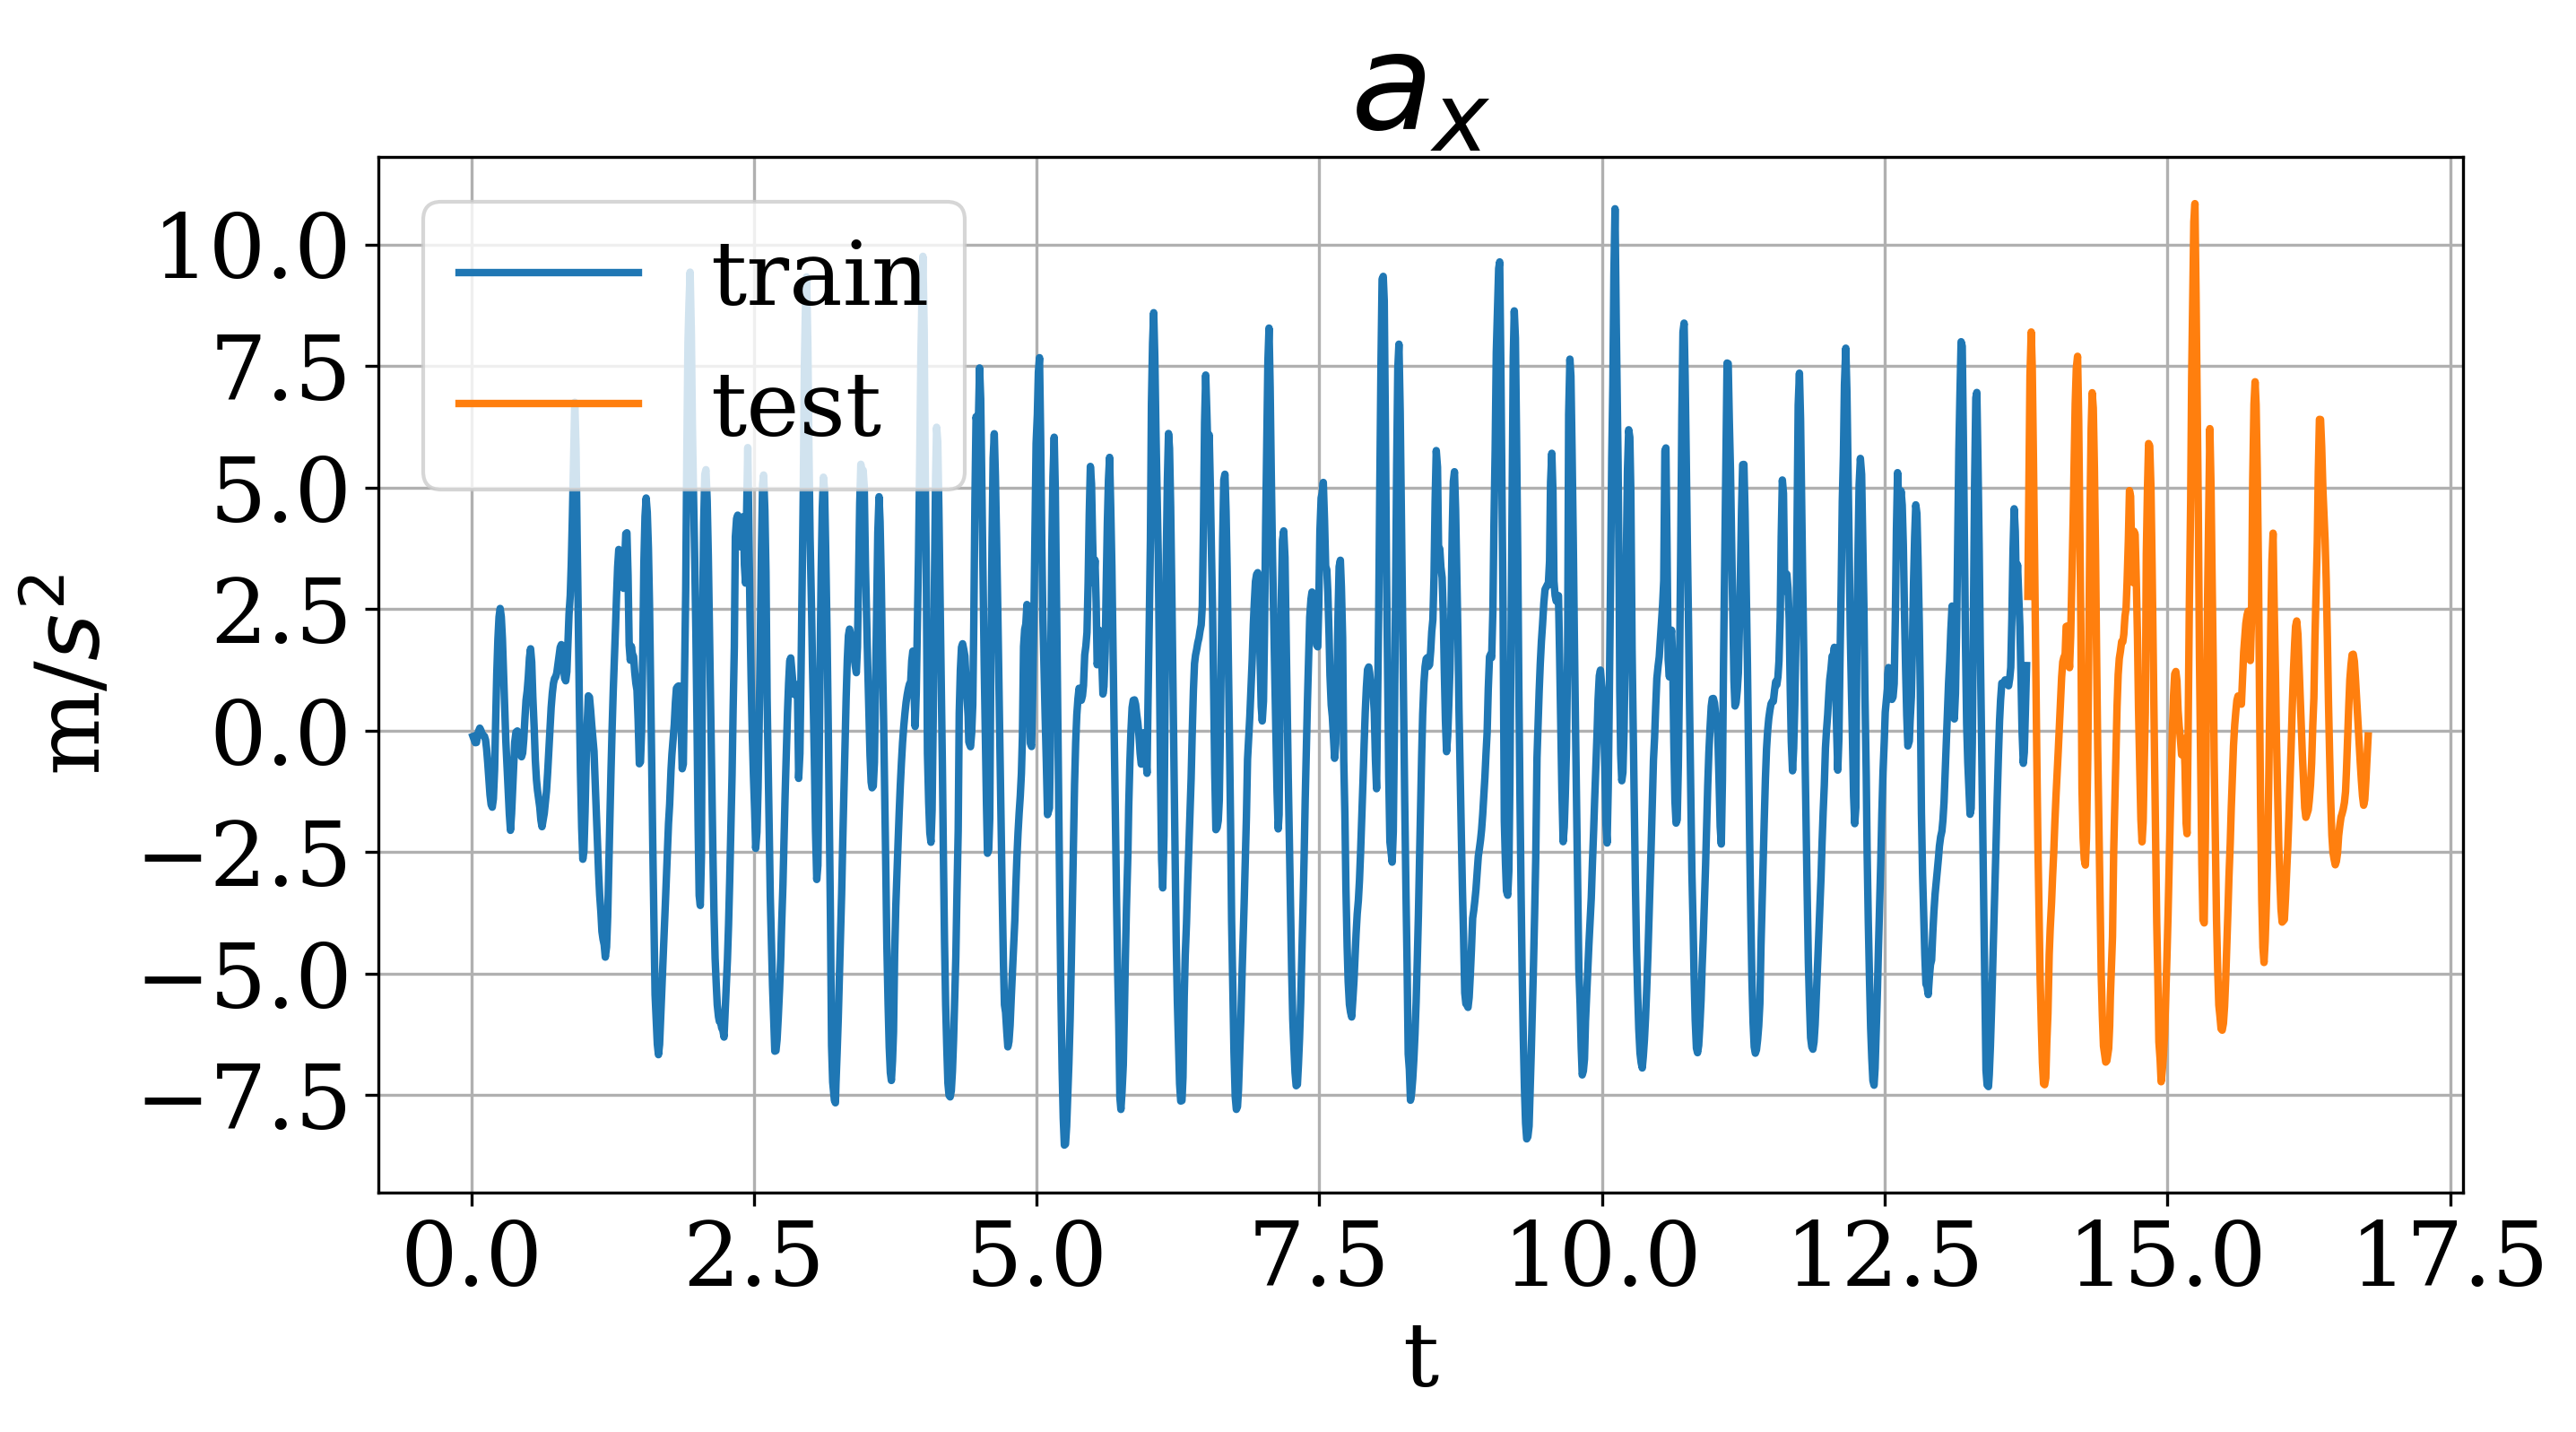

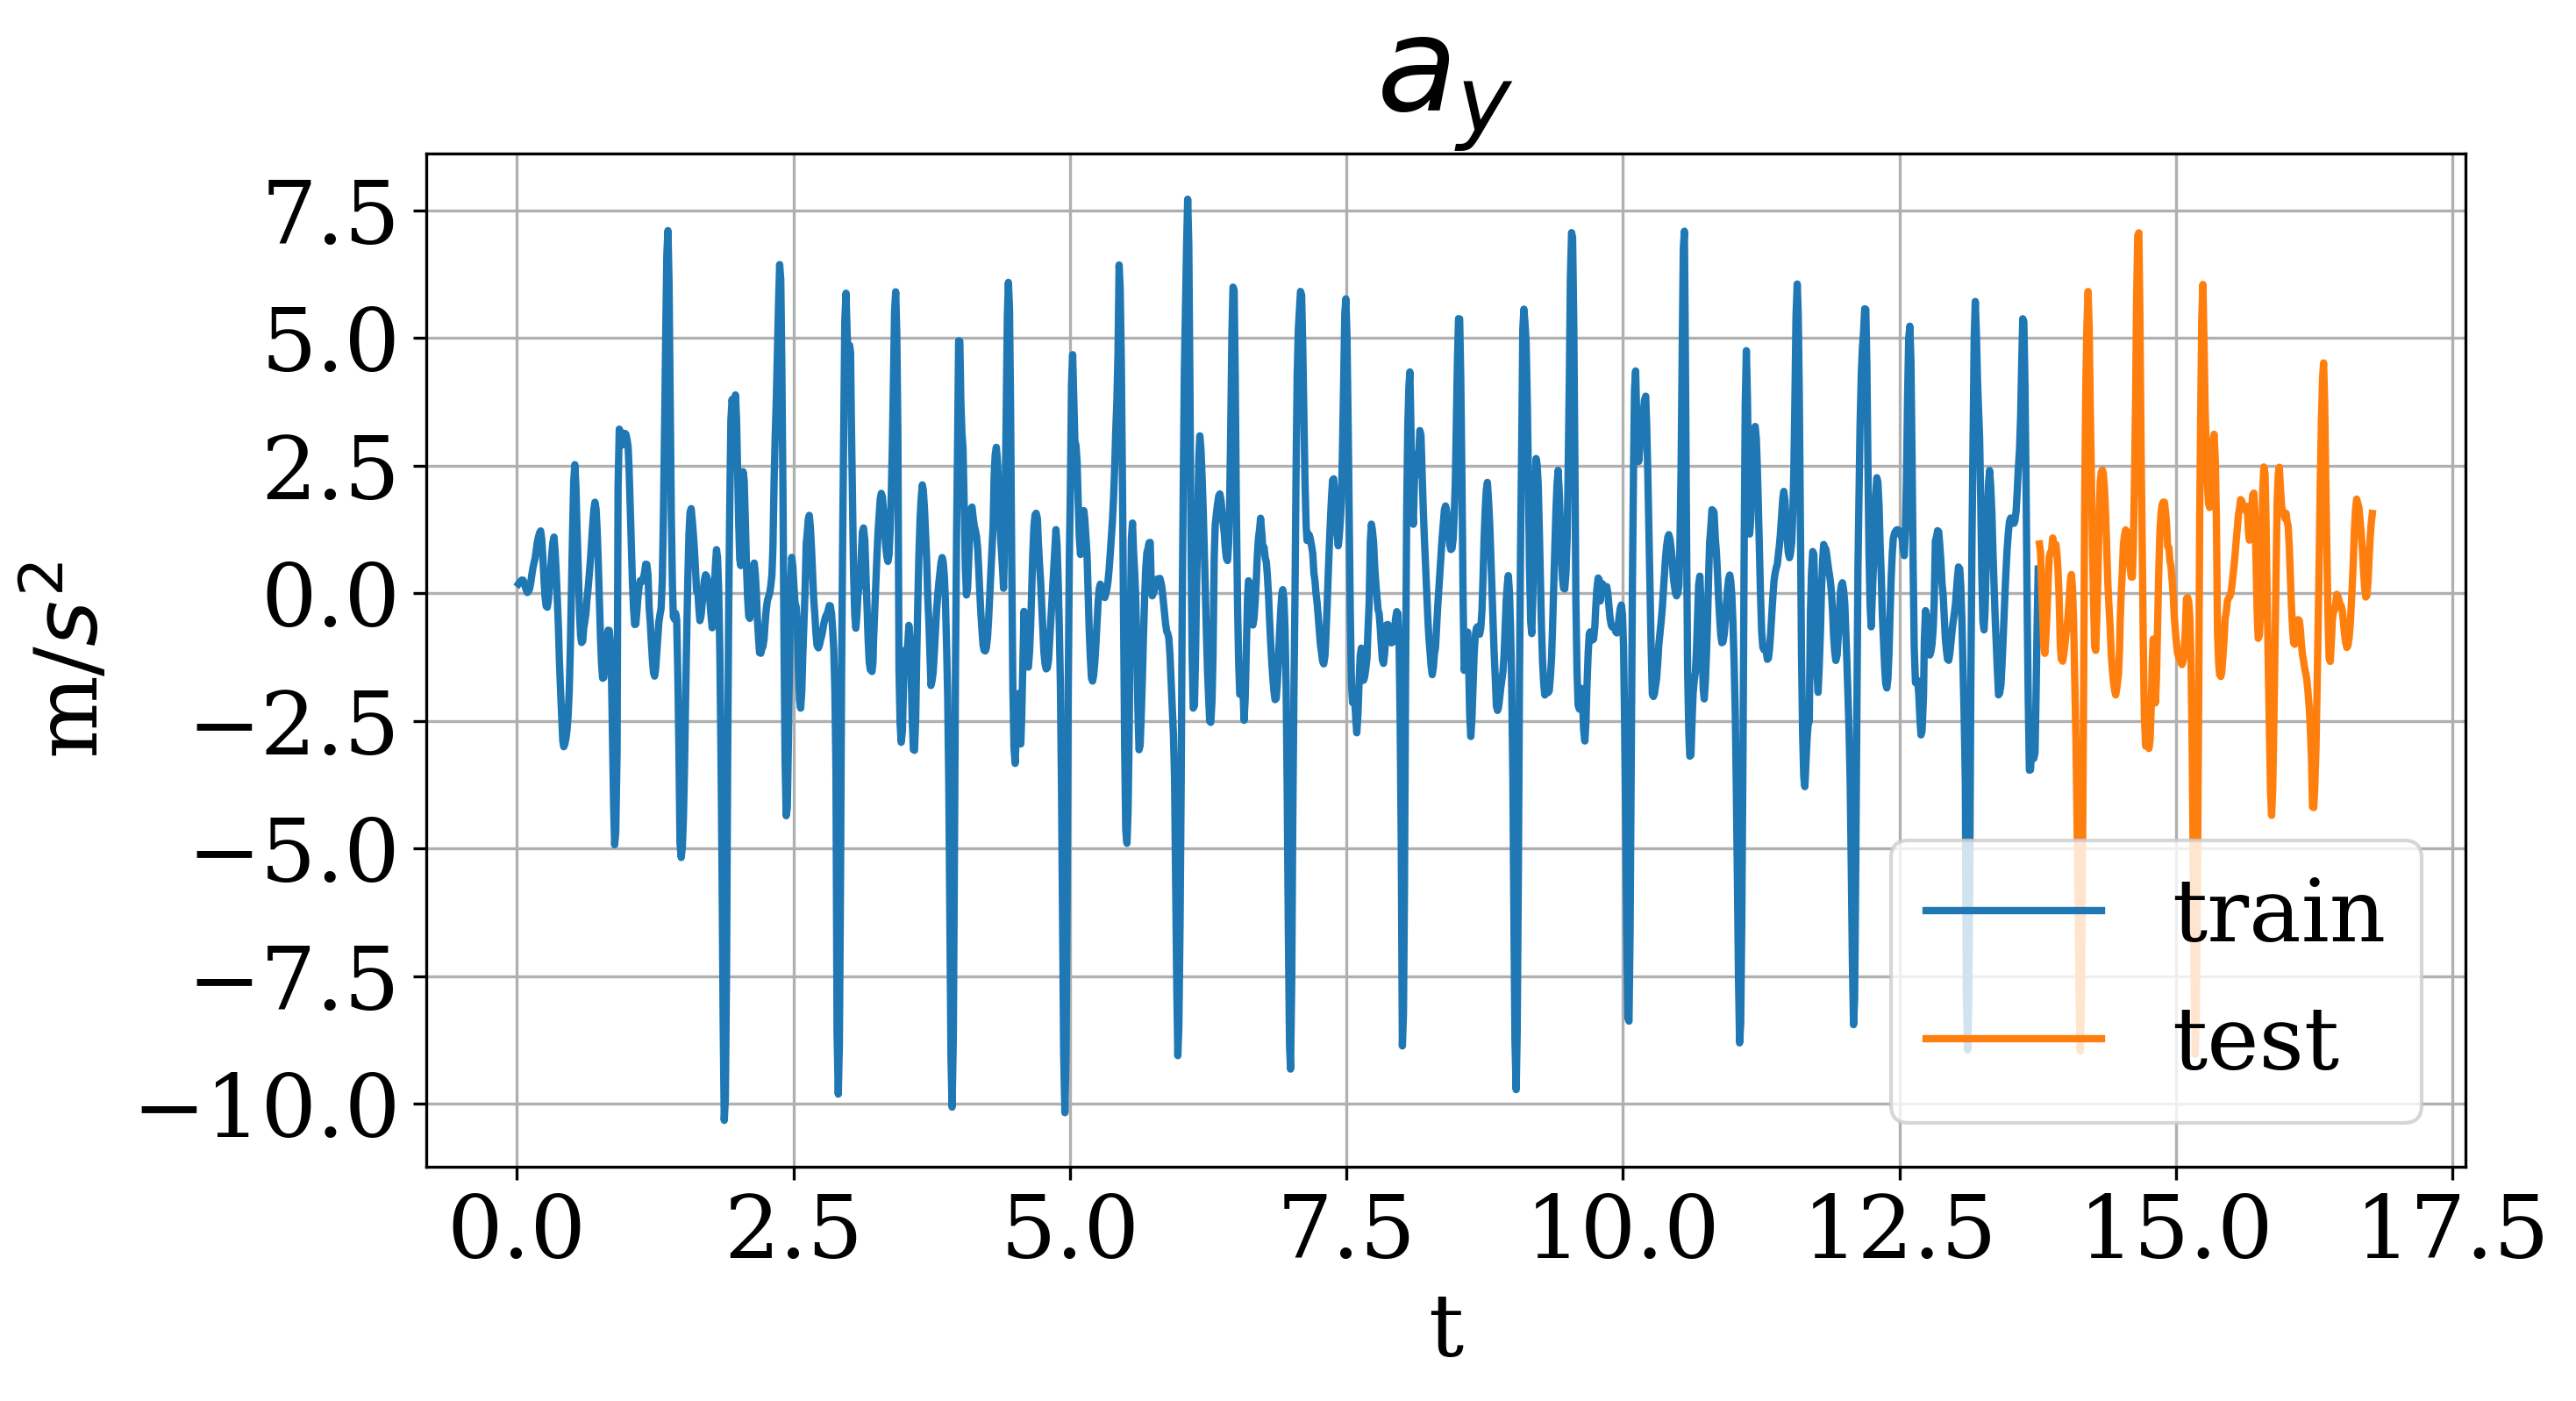

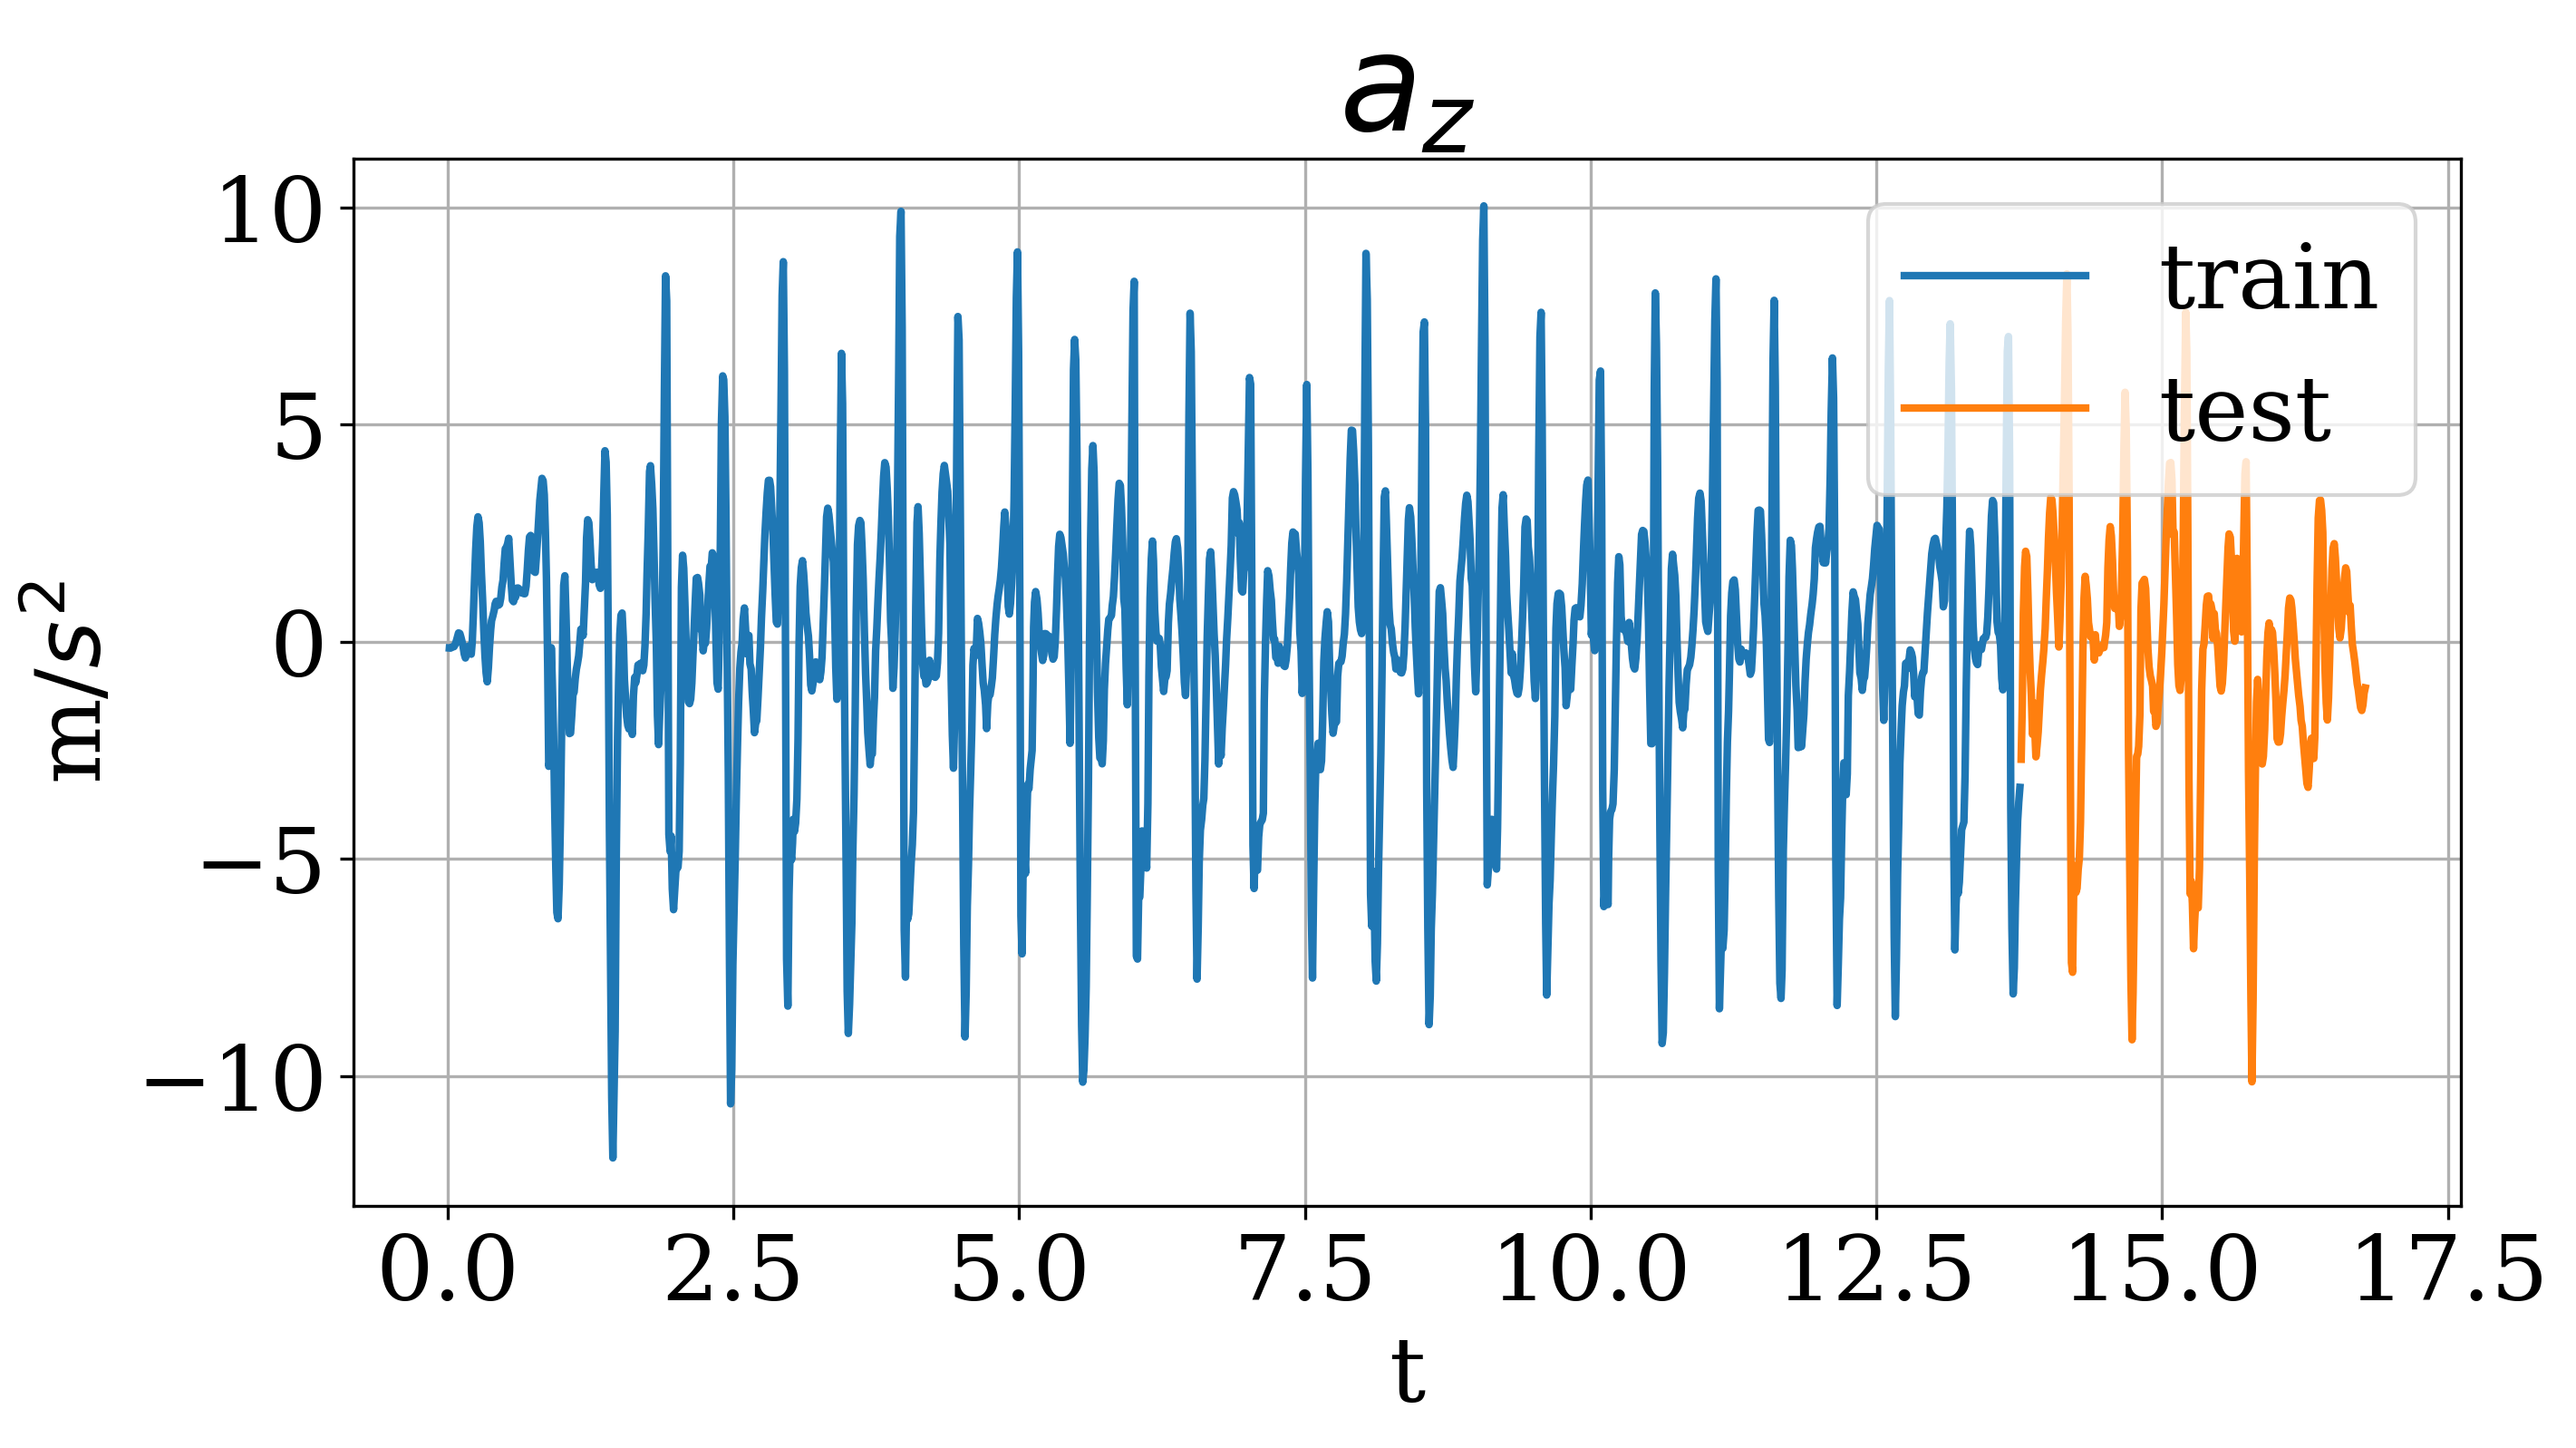

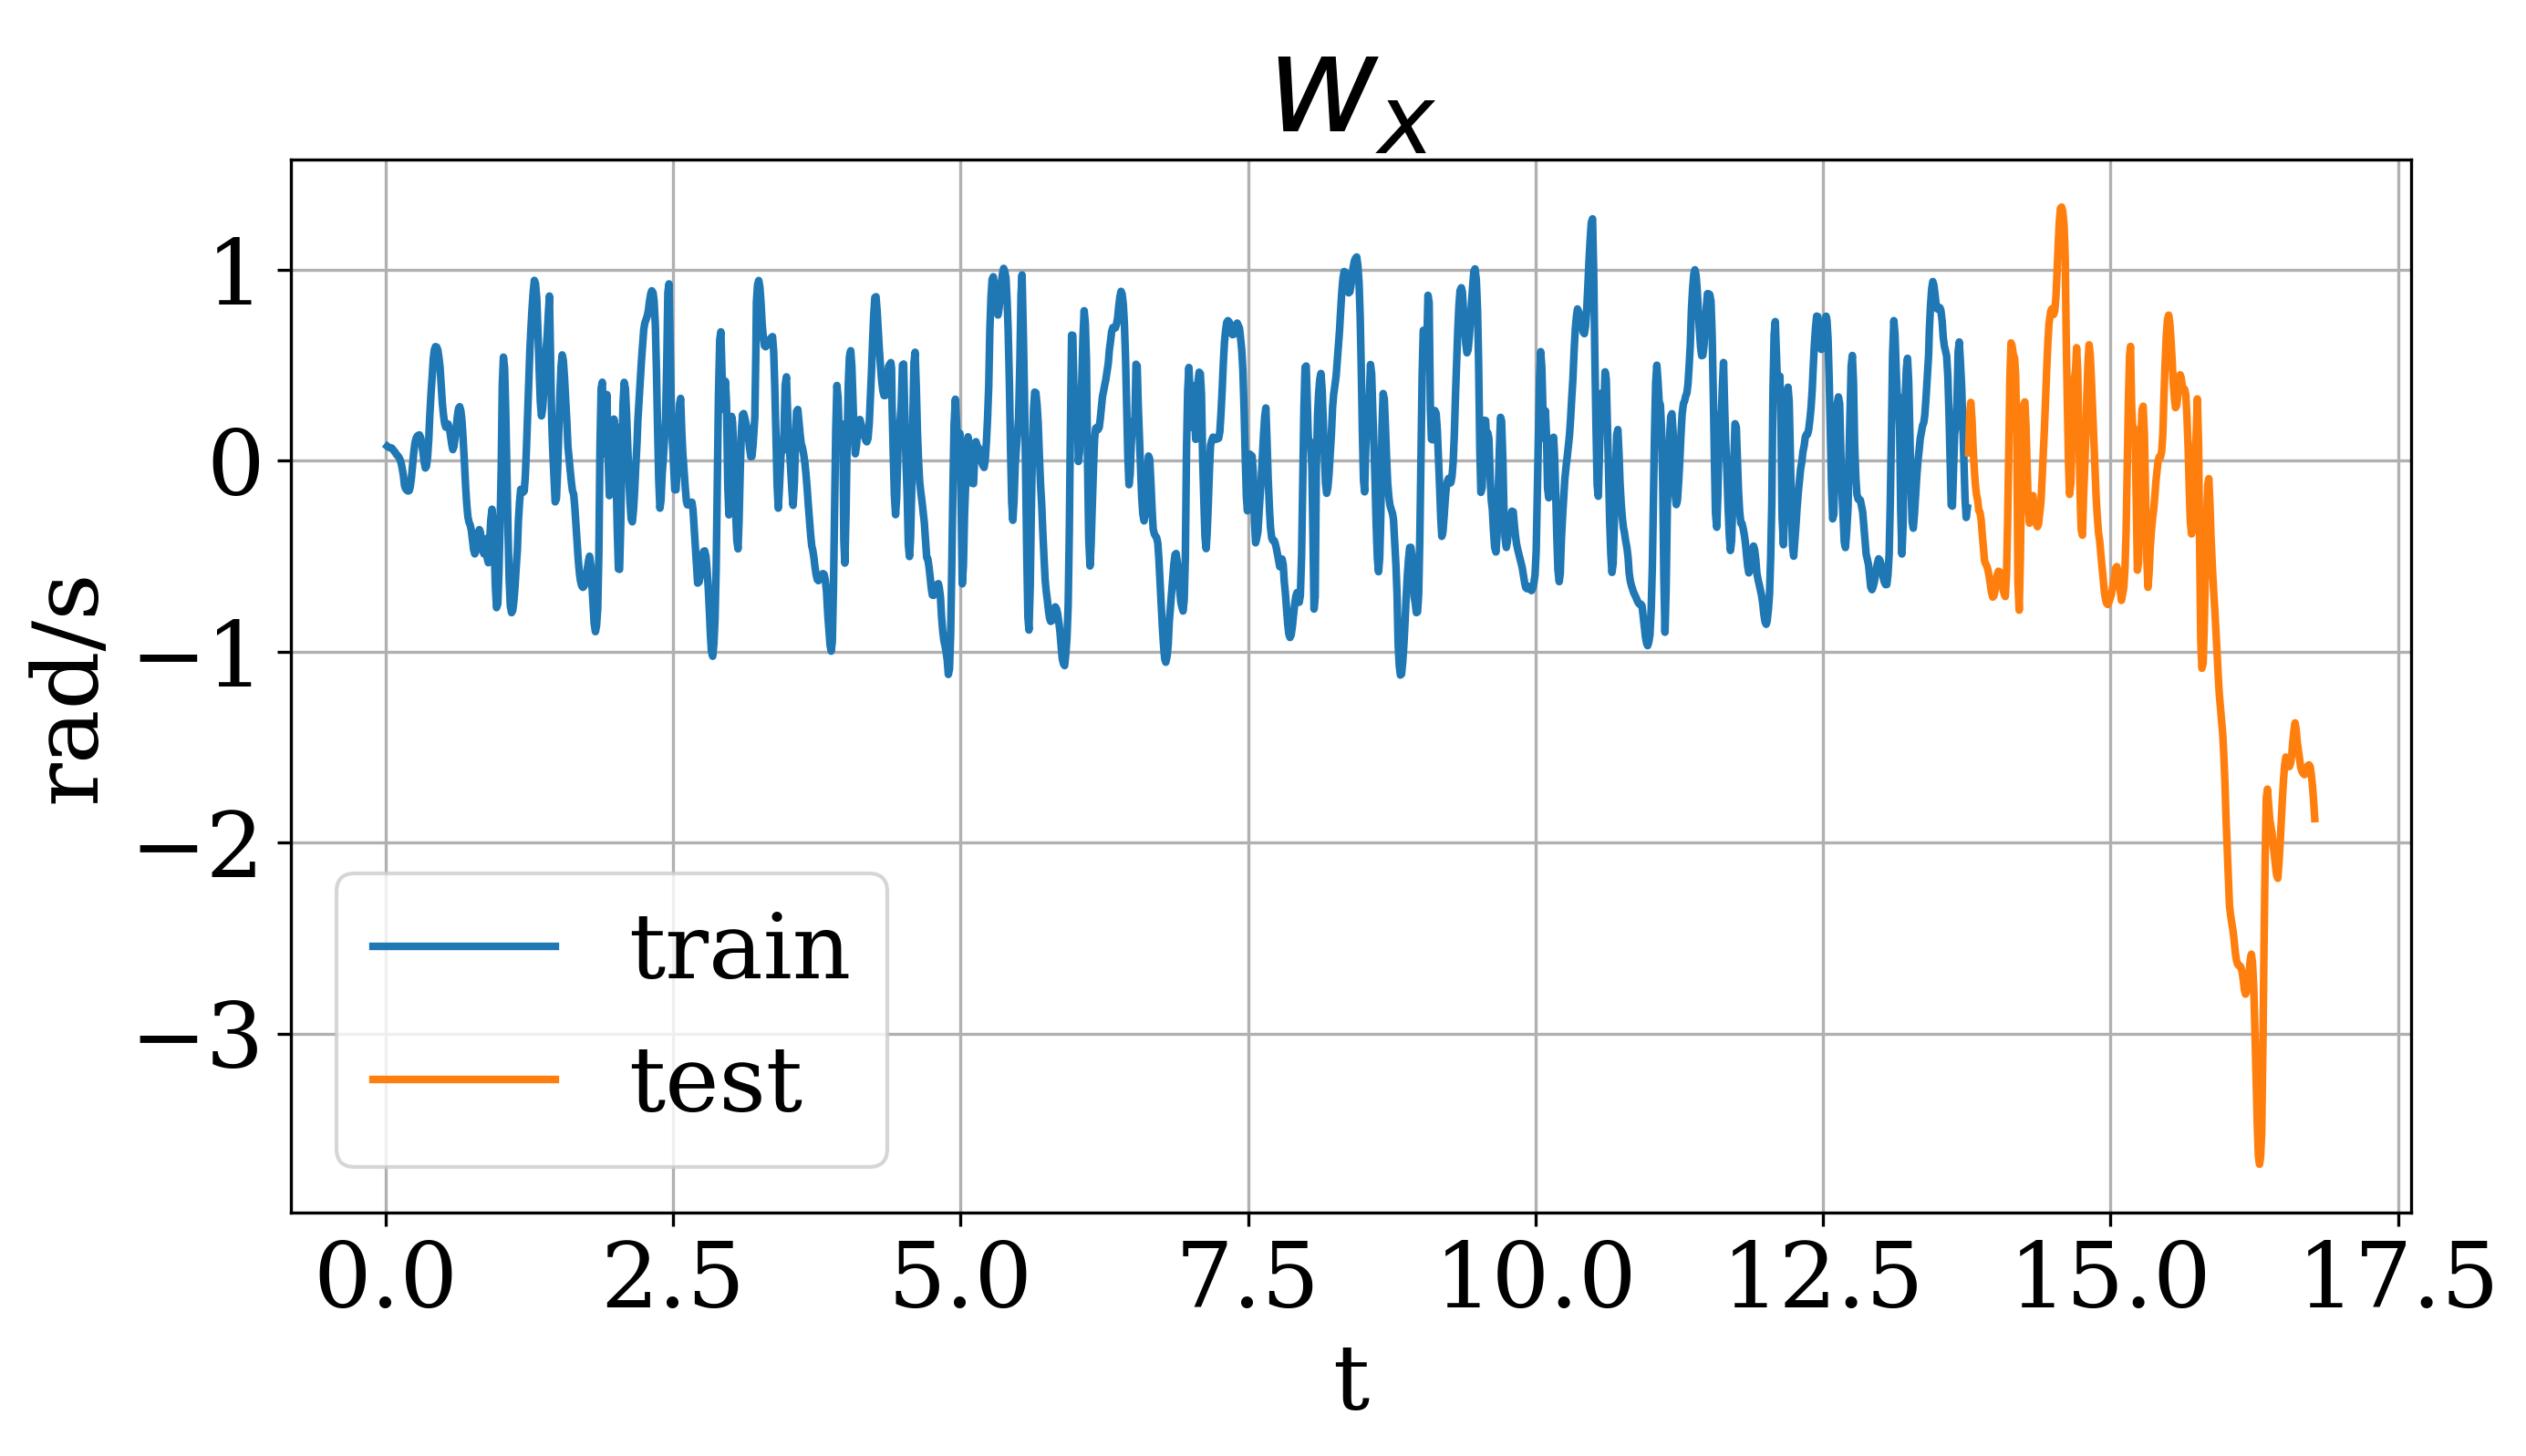

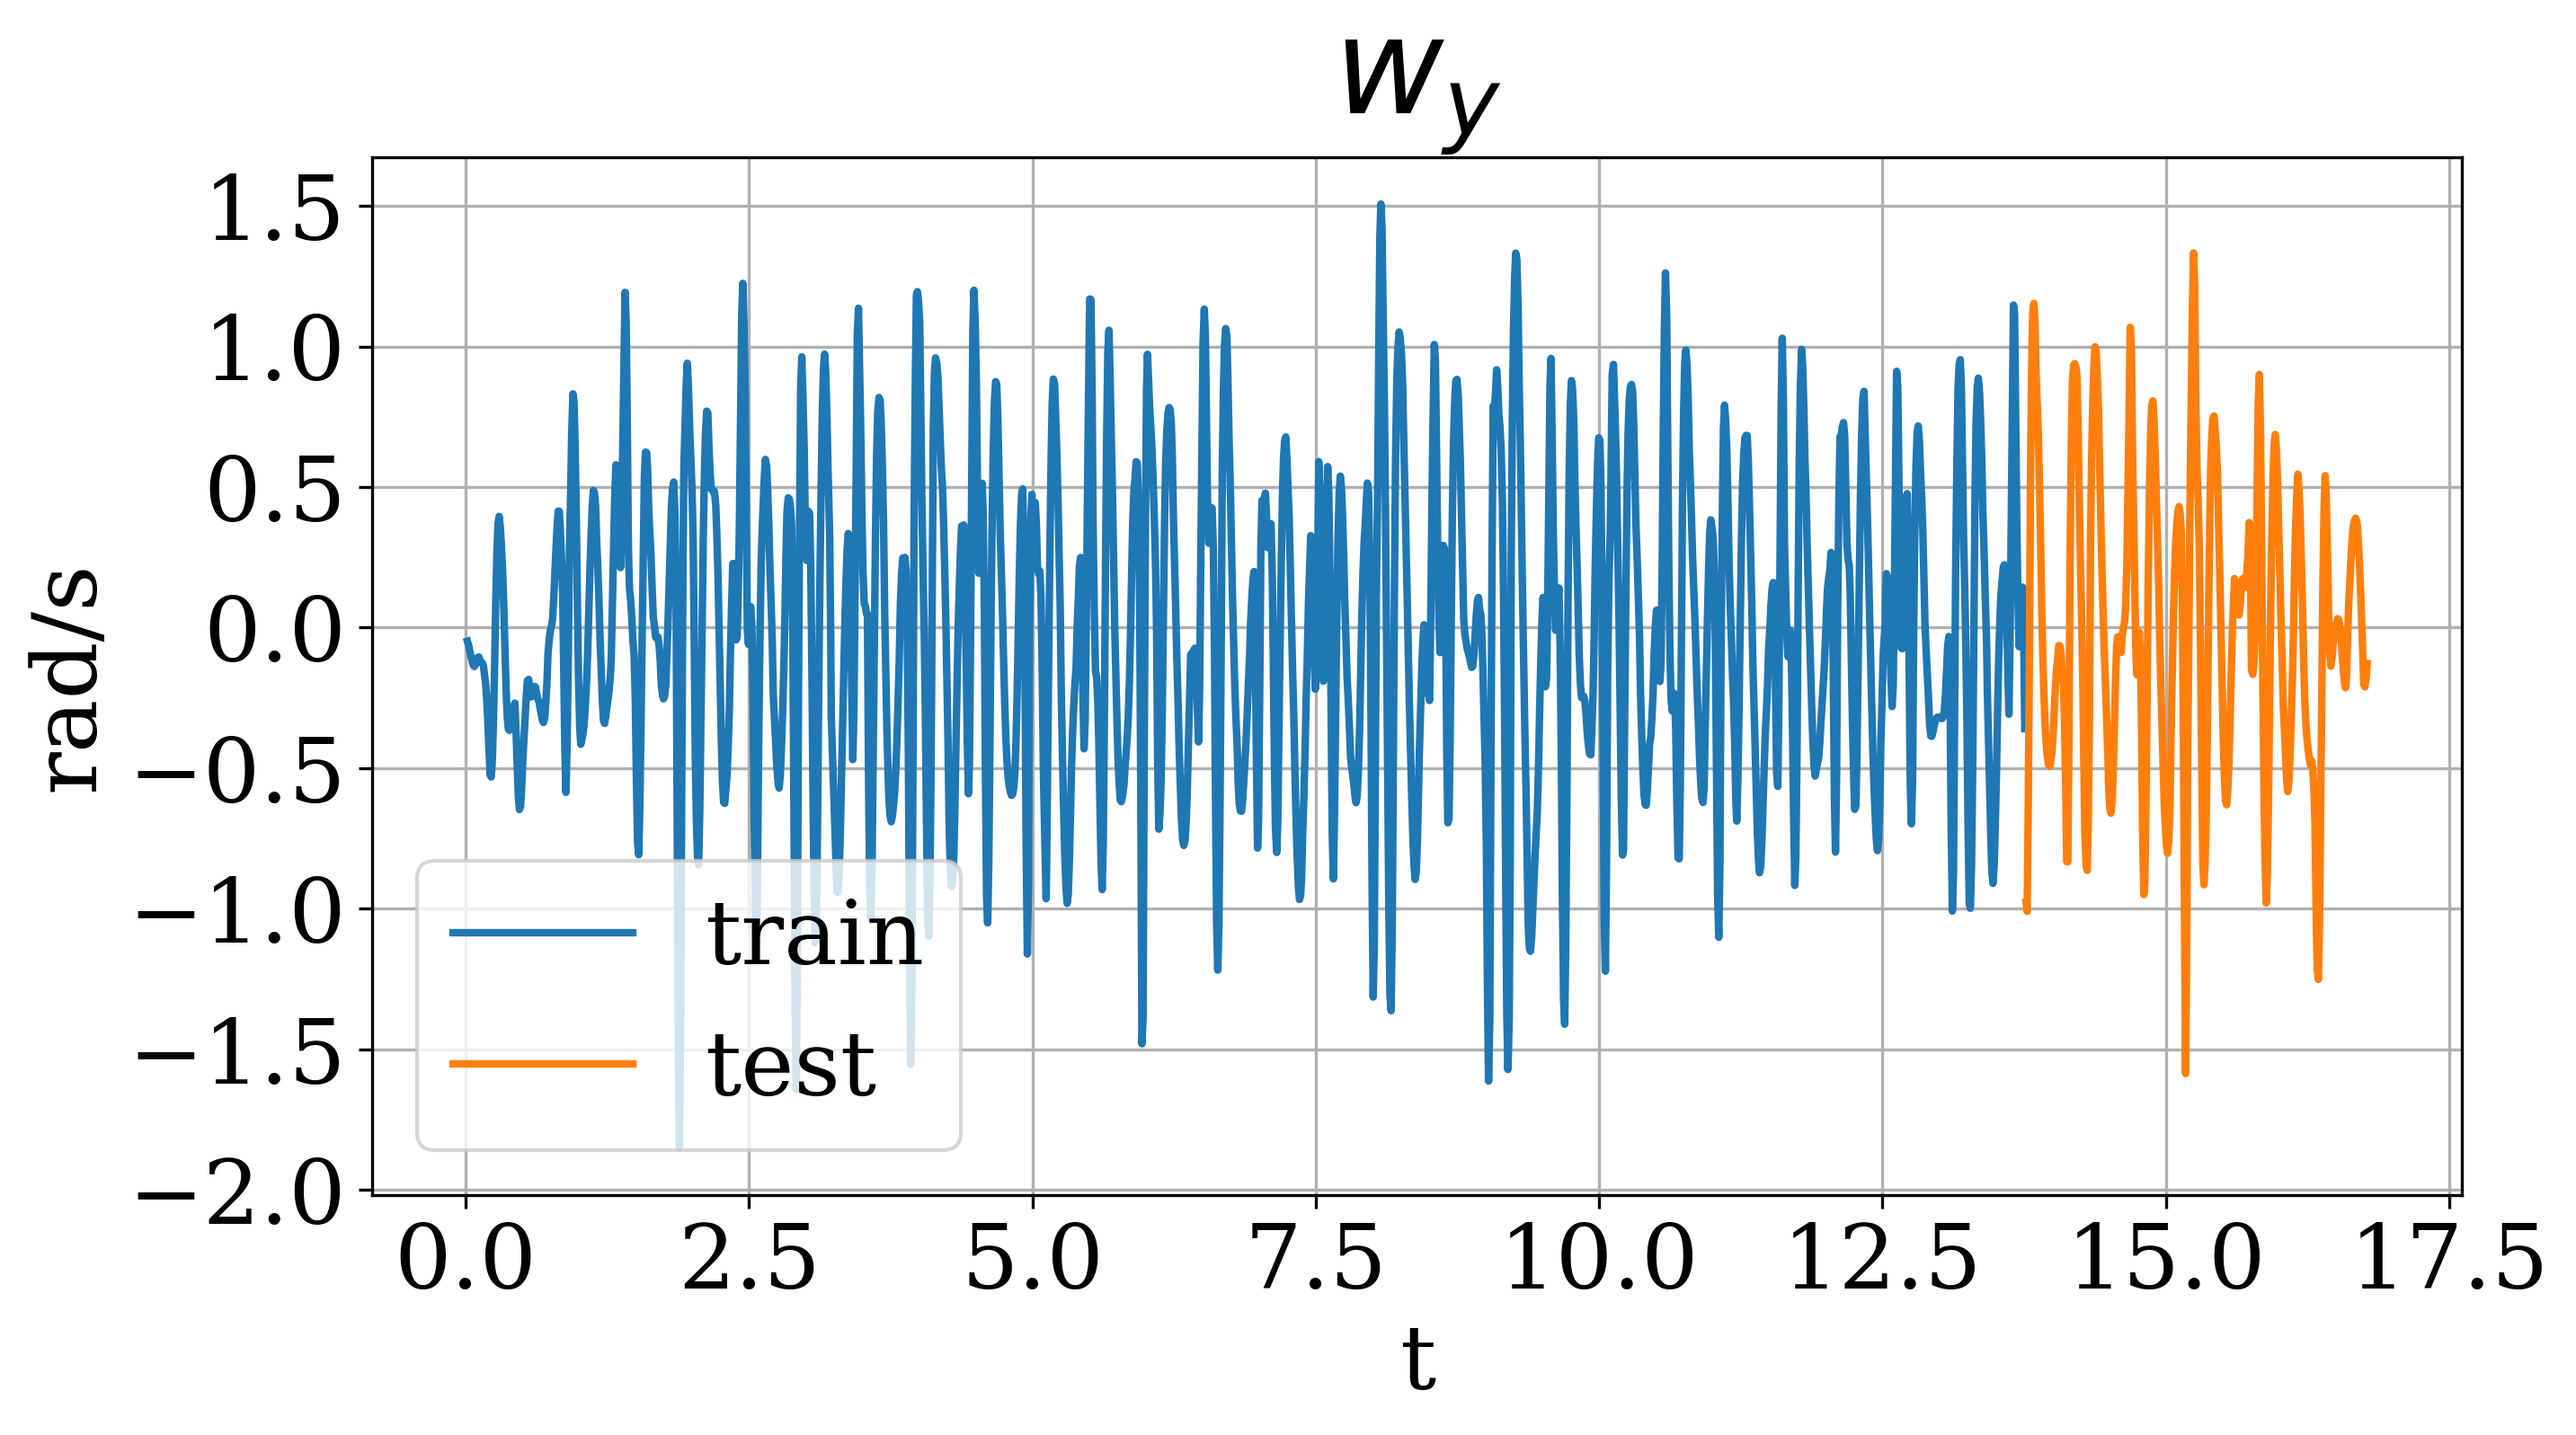

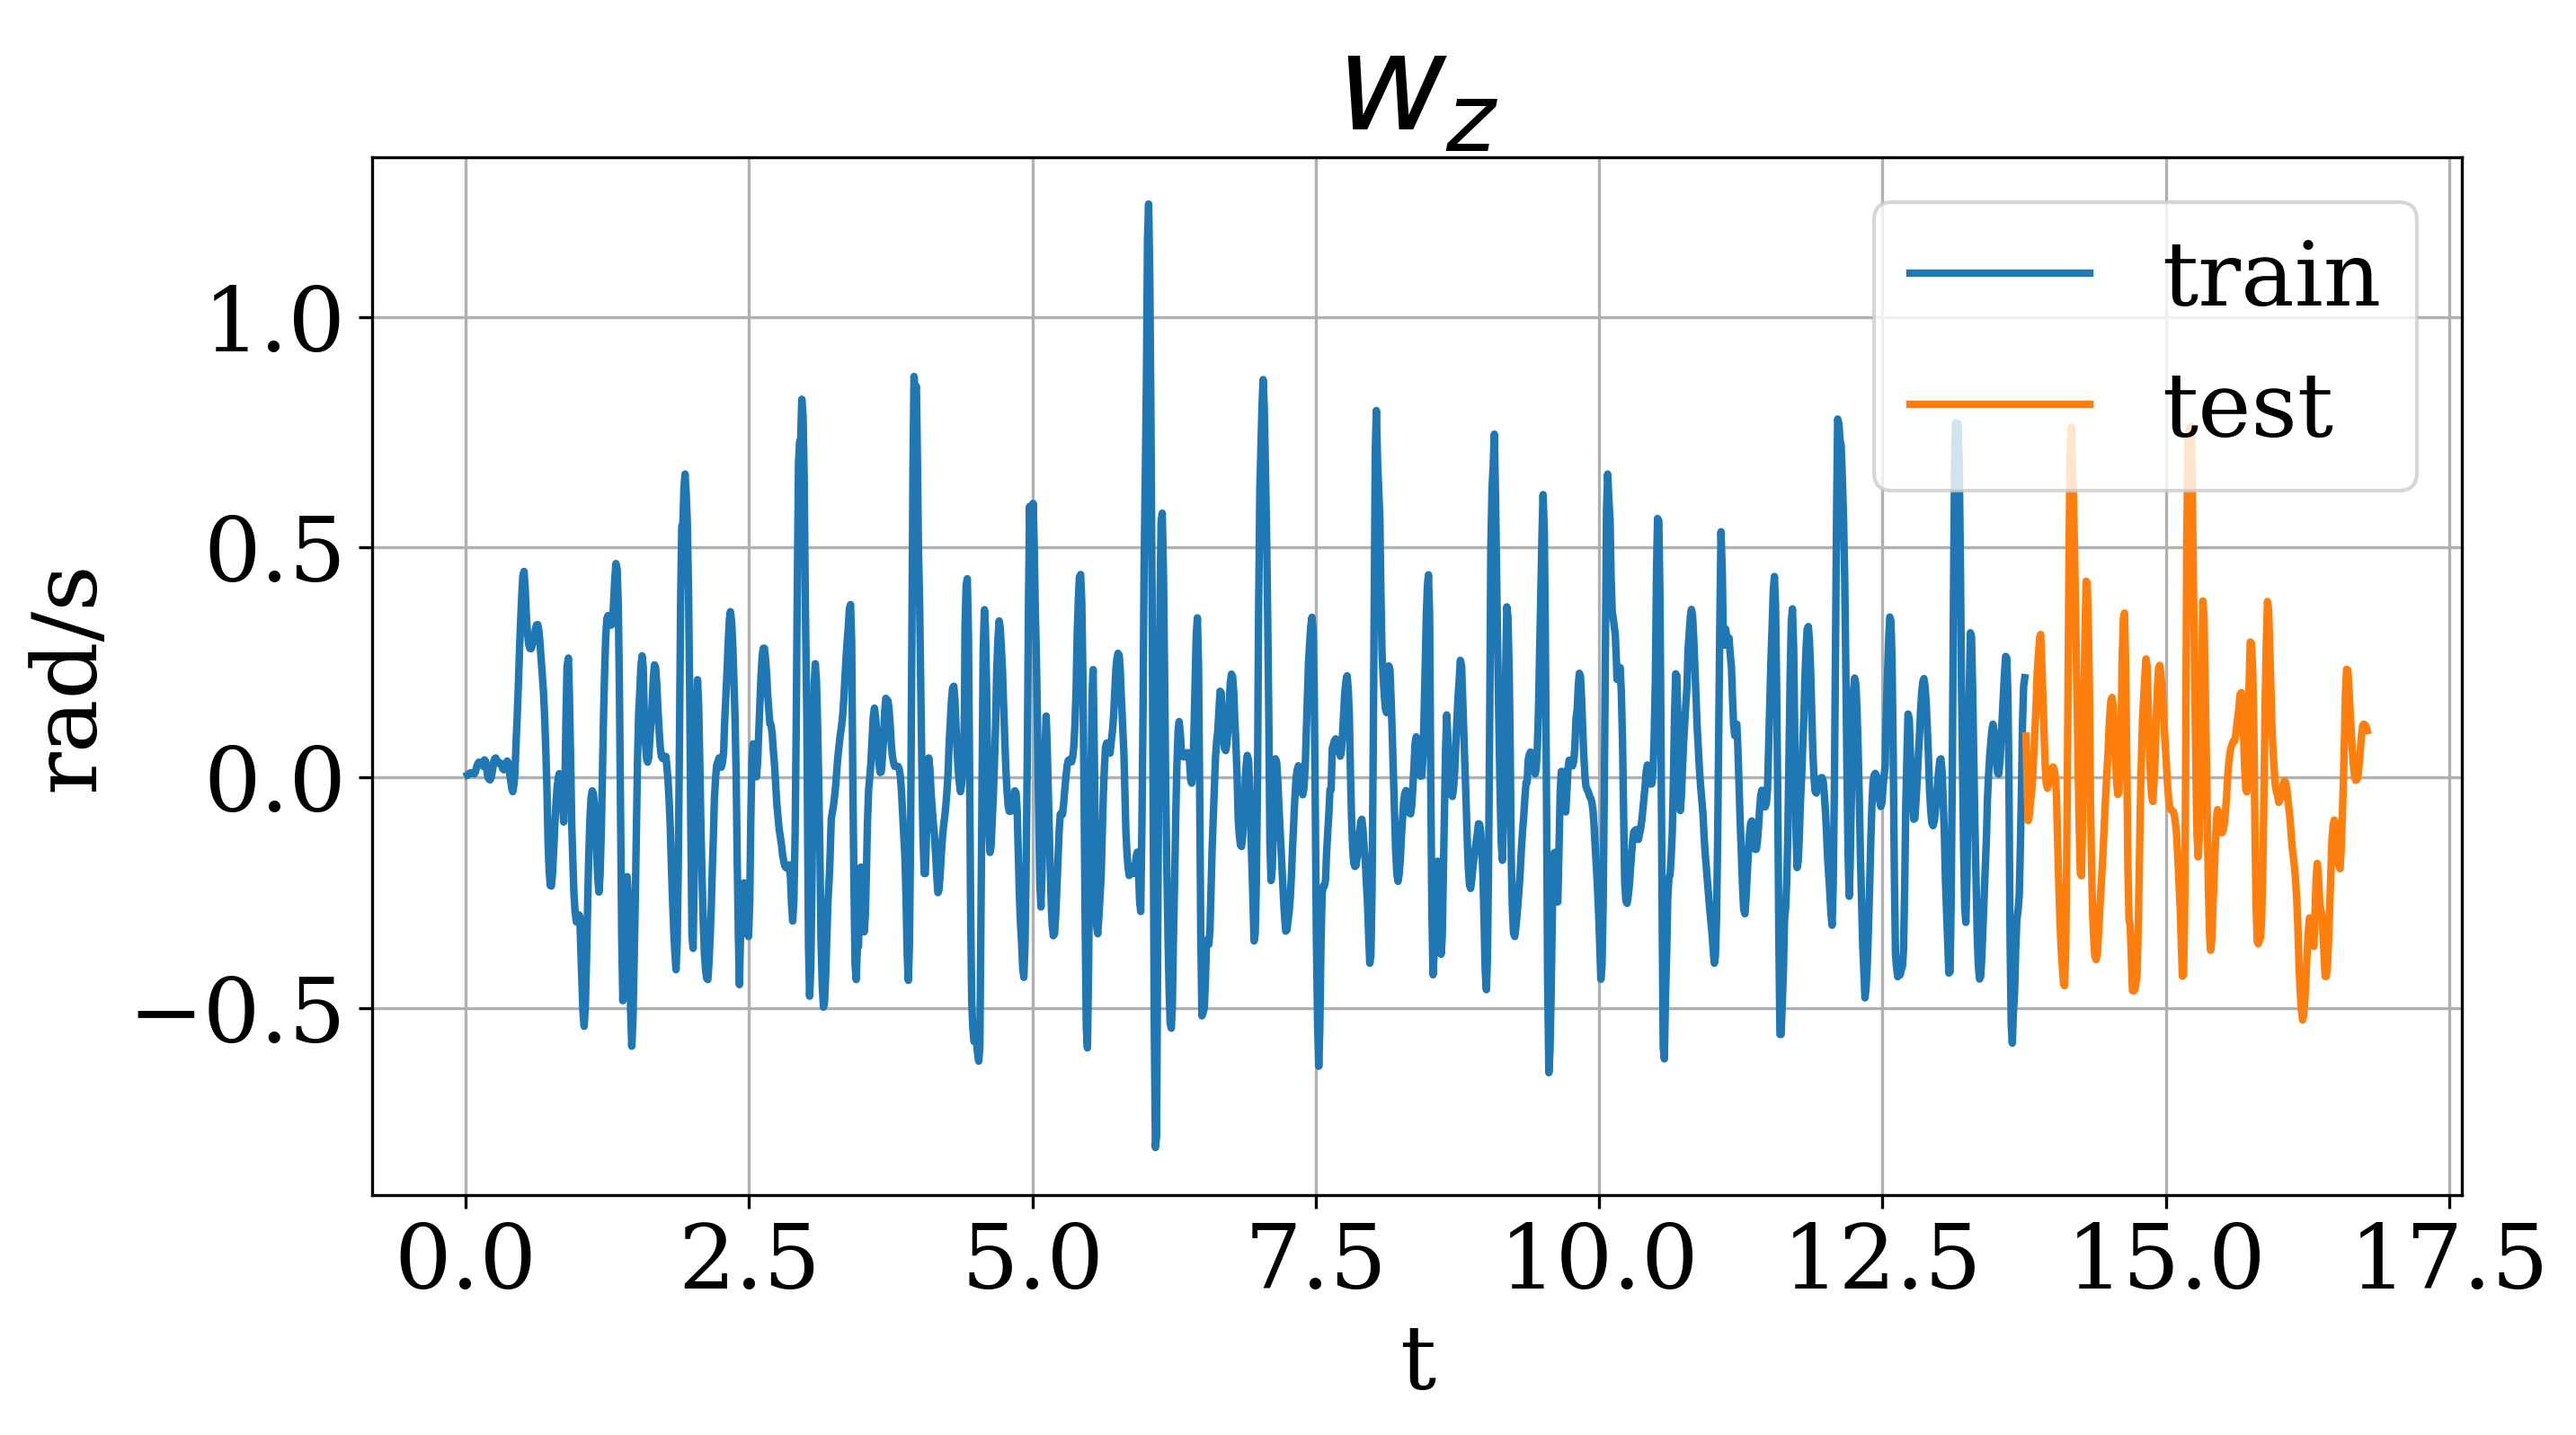

In [8]:
# draw signals
for i in range(num_signals):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(10, 5))

        ax.plot(time_grid_train, train_data.T[i], label='train')
        ax.plot(time_grid_test, test_data.T[i], label='test')

        ax.grid(True)
        ax.legend()
        ax.set_xlabel('t')
        ax.set_ylabel(sig_units[i])
        ax.set_title(sig_names[i])

In [9]:
# normalize data
train_mean = train_data.mean()
train_std = train_data.std()

test_mean = test_data.mean()
test_std = test_data.std()

train_data = (train_data - train_mean) / train_std
test_data = (test_data - test_mean) / test_std

In [10]:
# L parameter, for consitency across models in paper
window_size = 1000

In [11]:
batch_size = 64
num_samples = 350

# get slices from the time series (may overspan) and build dataset out of it
# length of the slices is set to be window_size
train_loader = data.GetTrainDataloader(
    train_time_series=train_data,
    len_in_batch=window_size,
    num_samples=num_samples,
    batch_size=batch_size
)

## Experiment

In [12]:
torch.cuda.empty_cache()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [13]:
# create folders for model backup and metrics
pathlib.Path(f'./backup').mkdir(exist_ok=True, parents=True)
pathlib.Path(f'./tensorboard').mkdir(exist_ok=True, parents=True)

Create rnn predicter model

In [14]:
input_dim = train_data.shape[1]
hidden_dim = 100
num_layers = 1

rnn_predictor = model.RnnSignalPredictor(
    input_dim,
    hidden_dim,
    num_layers
).to(device=device)

Tune other train parameters

In [15]:
log_writer = SummaryWriter(f'./tensorboard')

In [16]:
optimizer =torch.optim.Adam(rnn_predictor.parameters(), lr=0.01)

In [17]:
num_epochs = 101
batches_per_epoch = int(0.4 * num_samples) // batch_size + 1

backup_frequency = 50

In [18]:
for epoch_num in range(num_epochs):
    # train model
    epoch_losses = train.TrainEpoch(
        train_loader,
        rnn_predictor,
        optimizer,
        batches_per_epoch,
        device
    )

    # safe epoch loss
    for i in range(len(epoch_losses)):
        log_writer.add_scalar(
            'Train/MSE',
            epoch_losses[i].item(),
            epoch_num * batches_per_epoch + i
        )

    # backup model
    if epoch_num % backup_frequency == 0:
        train.BackupModel(
            rnn_predictor,
            f'./backup/rnn_predictor.pkl'
        )

    # compute metrics on test
    mse, mape = train.EvaluatePredictor(
        torch.from_numpy(train_data[-window_size:].copy()).to(dtype=torch.float32),
        torch.from_numpy(test_data).to(dtype=torch.float32),
        rnn_predictor,
        device=device
    )

    # safe metircs
    log_writer.add_scalars(
        'Test/MSE',
        dict(map(lambda tag, val: (tag, val), sig_names, mse.tolist())),
        epoch_num
    )
    log_writer.add_scalars(
        'Test/MAPE',
        dict(map(lambda tag, val: (tag, val), sig_names, mape.tolist())),
        epoch_num
    )
    
    log_writer.flush()

    # debug
    display.clear_output()
    display.display(f'Epoch {epoch_num}: last loss = {epoch_losses[-1]}; mse, mape on test = {(mse, mape)}')

'Epoch 100: last loss = 0.004676913842558861; mse, mape on test = (array([2.1842449 , 1.182694  , 2.4113927 , 0.35812703, 0.0785107 ,\n       0.02208154], dtype=float32), array([3.4935913, 3.1474202, 3.0540824, 1.9889305, 3.5132766, 3.57795  ],\n      dtype=float32))'

In [19]:
log_writer.close()

### Prediction

In [20]:
# get prediction
rnn_forecast = None

rnn_predictor.eval()

with torch.no_grad():
    test_len = test_data.shape[0]

    # get last series values
    context = torch.from_numpy(train_data[-window_size:].copy()).to(dtype=torch.float32)
    # add batch dim to context and put it on device
    context = context.unsqueeze(0).to(device=device)

    # obtain predictions
    rnn_forecast = rnn_predictor.predict(test_len, context)
    # remove batch dimension and put it on kernal
    rnn_forecast = rnn_forecast.squeeze(0).to(device='cpu').numpy()

In [21]:
# make reverse data transformation
rnn_forecast = rnn_forecast * test_std + test_mean
test_data = test_data * test_std + test_mean

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


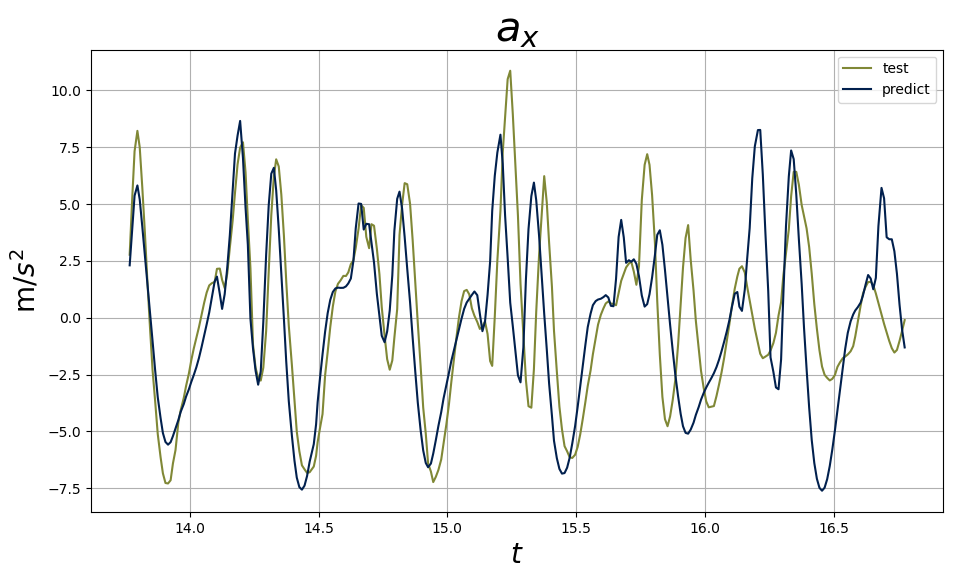

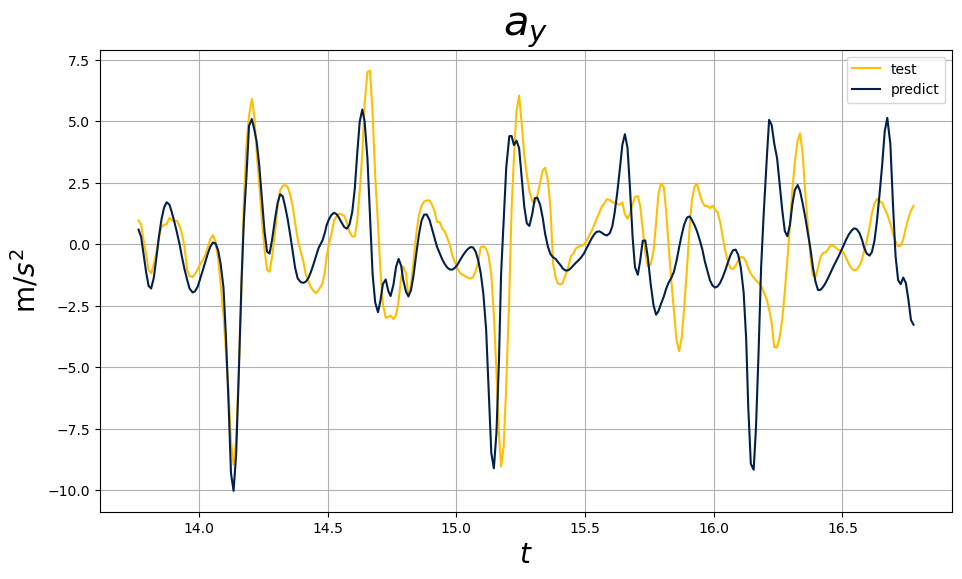

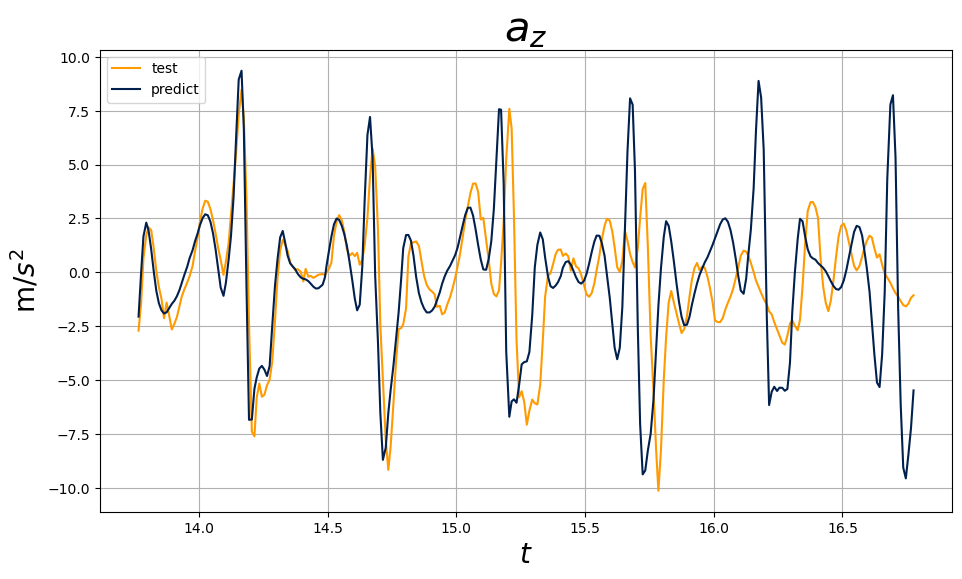

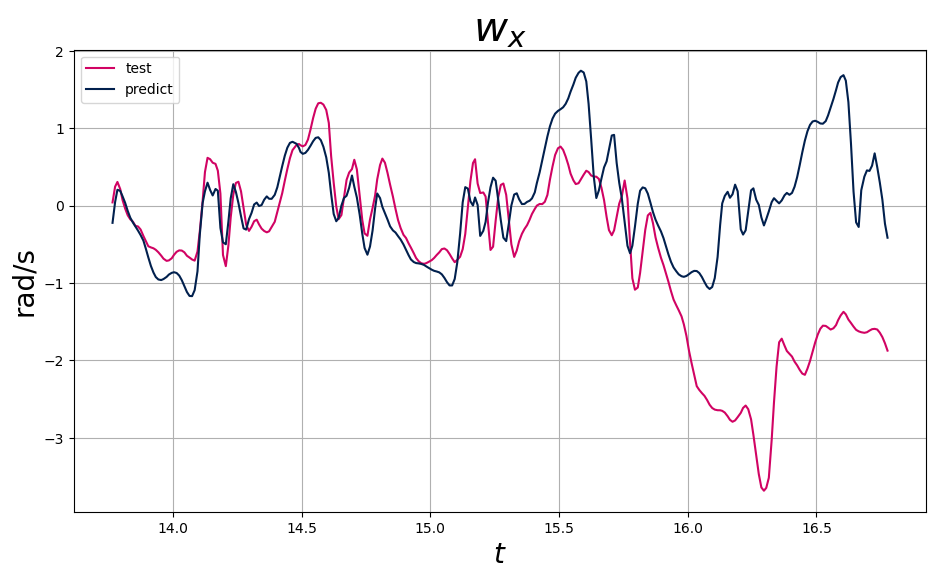

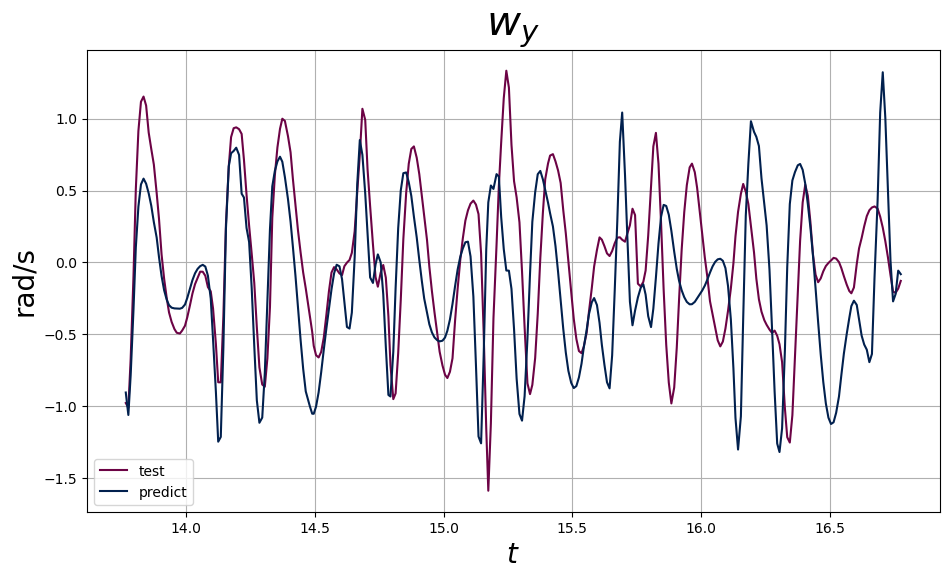

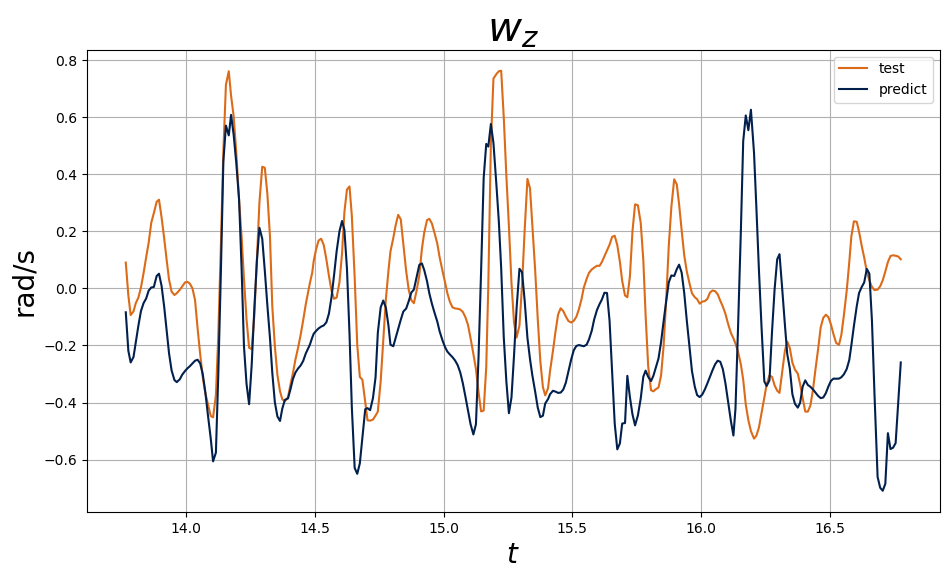

In [23]:
pathlib.Path("./figs/prediction").mkdir(exist_ok=True, parents=True)

# colours for our signals (https://colorhunt.co/palette/808836ffbf00ff9a00d10363)
color_list = ['#808836', '#FFBF00', '#FF9A00', "#D10363", "#6C0345", "#DC6B19", "#01204E"]

# plot prediction and real values
for i in range(test_data.shape[1]):
    fig, ax = plt.subplots(figsize=(11, 6))

    ax.plot(time_grid_test, test_data.T[i], color=color_list[i], label='test')
    ax.plot(time_grid_test, rnn_forecast.T[i], color=color_list[-1], label='predict')

    ax.grid(True)
    ax.legend();
    ax.set_ylabel(f'{sig_units[i]}', fontsize=20)
    ax.set_xlabel('$t$', fontsize=20)
    ax.set_title(f'{sig_names[i]}', fontsize=30)

    fig.savefig(f'./figs/prediction/{sig_names[i].replace(" ", "_")}.eps',
                             format='eps')

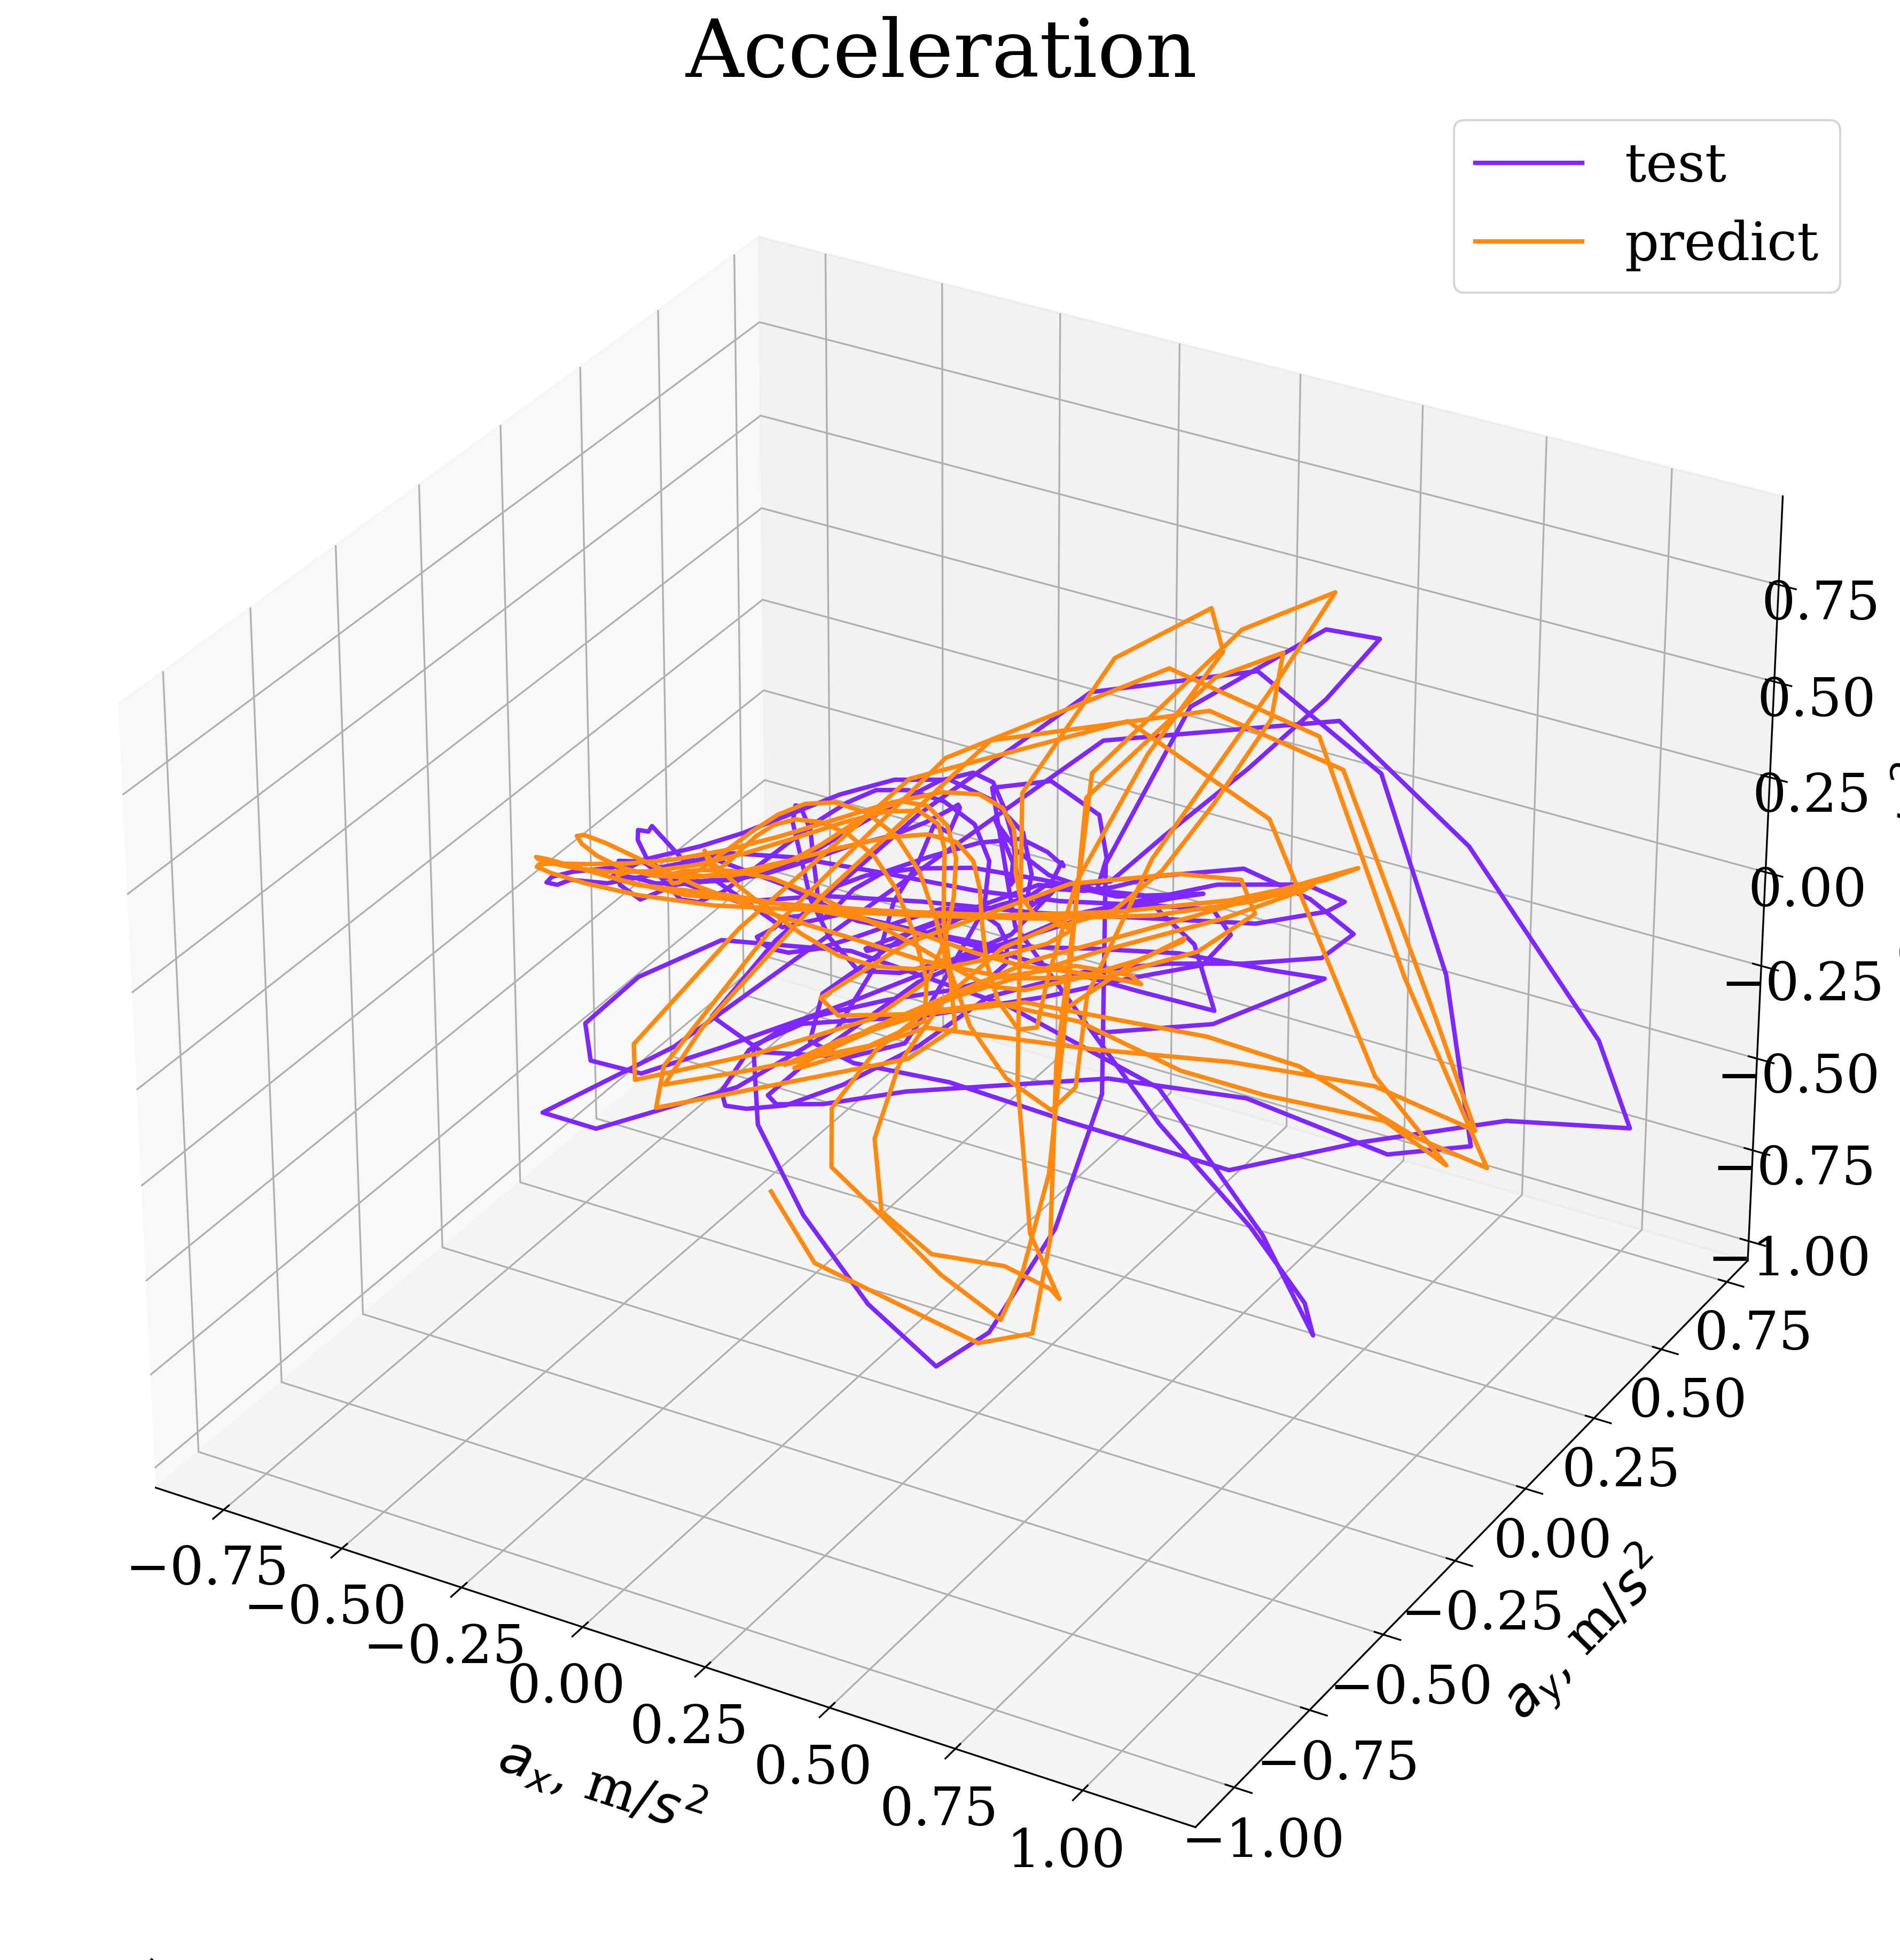

In [24]:
# 3d acceler plots
component_colors = ["#7F27FF", "#FF8911"]

# make directory for figures
pathlib.Path(f'./figs/prediction').mkdir(parents=True, exist_ok=True)

with EnableJournalStylePlotting():
    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(projection='3d')

    ax.plot(*(test_data.T[:3]), color=component_colors[0], label="test")
    ax.plot(*(rnn_forecast.T[:3]), color=component_colors[1], label="predict")

    ax.set_xlabel(f"{sig_names[0]}, {sig_units[0]}", labelpad=21)
    ax.set_ylabel(f"{sig_names[1]}, {sig_units[1]}", labelpad=21)
    ax.set_zlabel(f"{sig_names[2]}, {sig_units[2]}", labelpad=21)
    ax.set_title(f"Acceleration")
    ax.legend()

    for axis in ["x", "y", "z"]:
        ax.ticklabel_format(axis=axis, style="scientific", scilimits=(0, 0))
    
    fig.savefig(f"./figs/prediction/acceler.png", format='png')

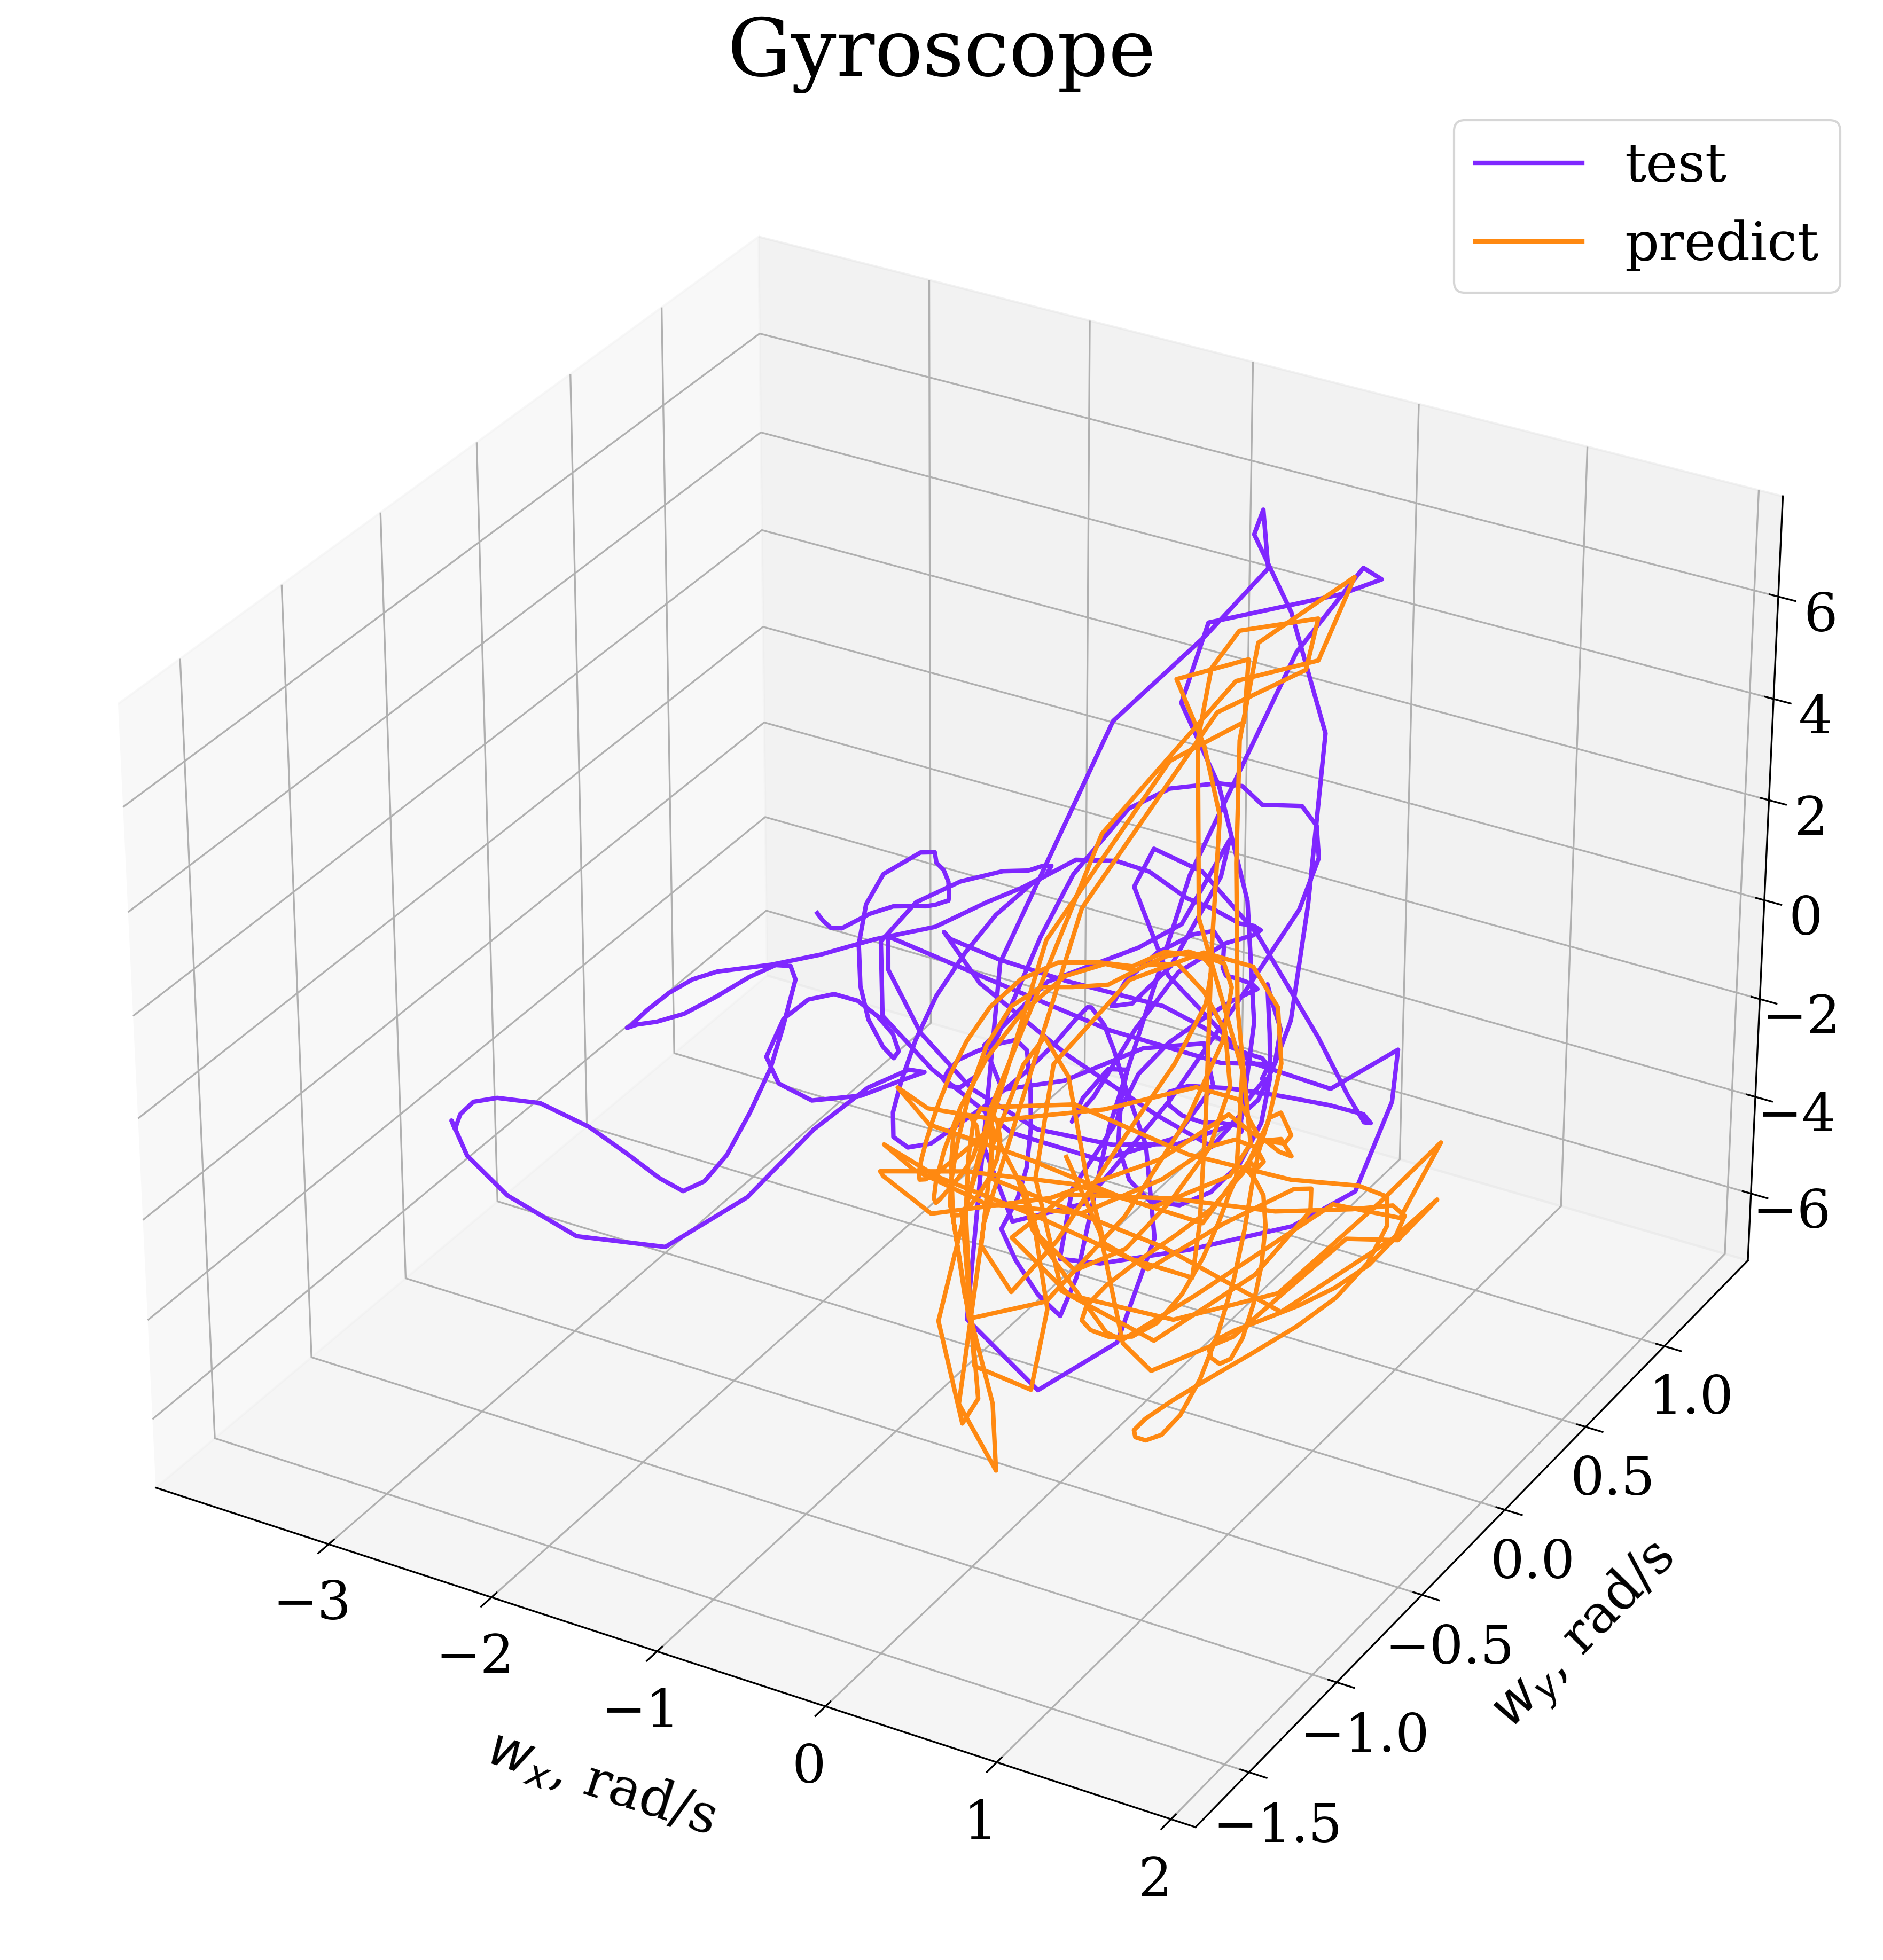

In [25]:
# 3d gyro plots
component_colors = ["#7F27FF", "#FF8911"]

with EnableJournalStylePlotting():
    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(projection='3d')

    ax.plot(*(test_data.T[3:]), color=component_colors[0], label="test")
    ax.plot(*(rnn_forecast.T[3:]), color=component_colors[1], label="predict")

    ax.set_xlabel(f"{sig_names[3]}, {sig_units[3]}", labelpad=21)
    ax.set_ylabel(f"{sig_names[4]}, {sig_units[4]}", labelpad=21)
    ax.set_zlabel(f"{sig_names[5]}, {sig_units[5]}", labelpad=21)
    ax.set_title(f"Gyroscope")
    ax.legend()

    for axis in ["x", "y", "z"]:
        ax.ticklabel_format(axis=axis, style="scientific", scilimits=(0, 0))
    
    fig.savefig(f"./figs/prediction/gyro.png", format='png')

In [26]:
with open("./backup/rnn_predictor.pkl", "rb") as f:
    rnn_predictor = pickle.load(f)

rnn_predictor = rnn_predictor.to(device="cpu")

In [27]:
# compute metrics
rnn_mse_metric, rnn_mape_metric = train.EvaluatePredictor(
        torch.from_numpy(train_data[-window_size:].copy()).to(dtype=torch.float32),
        torch.from_numpy(test_data).to(dtype=torch.float32),
        rnn_predictor,
        device="cpu"
    )

print(f'MSE = {rnn_mse_metric}\nMAPE = {rnn_mape_metric}')
print(f'MSE mean = {np.mean(rnn_mse_metric)}\nMAPE mean = {np.mean(rnn_mape_metric)}')

# create dataframe for metrics
metrics_frame = pd.DataFrame({'MSE': [rnn_mse_metric], 'MAPE': [rnn_mape_metric]}, index=['VAR'])

MSE = [8.90923    4.09697    6.804304   1.6148486  0.2454429  0.05722459]
MAPE = [ 1.554295   1.3181322  2.3686786 10.725917   3.204422   2.9923983]
MSE mean = 3.6213369369506836
MAPE mean = 3.6939735412597656


In [28]:
print(f'Acc MSE: {np.mean(rnn_mse_metric[:3])}')
print(f'Acc MAPE: {np.mean(rnn_mape_metric[:3])}')

print(f'Gyro MSE: {np.mean(rnn_mse_metric[3:])}')
print(f'Gyro MAPE: {np.mean(rnn_mape_metric[3:])}')

Acc MSE: 6.603501796722412
Acc MAPE: 1.7470351457595825
Gyro MSE: 0.6391720175743103
Gyro MAPE: 5.6409125328063965
